In [1]:
import time, datetime
import requests 
import pickle as pkl 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import json

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn import metrics
import time


import warnings
warnings.filterwarnings('ignore')


from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support


In [3]:
from sklearn.model_selection import train_test_split


In [4]:
label_data = pd.read_pickle(r'all_metrics_data.pkl')
label_data.head()

len(label_data.columns)

201

In [5]:
from scipy import stats
import pprint

labels_to_correlate = label_data.drop(['label', 'time'], axis=1)

correlation_txn_falure = {}
for label in labels_to_correlate.columns:
    r,p = stats.pearsonr(labels_to_correlate[label], label_data.label)
    correlation_txn_falure[label] = (r,p)

In [6]:
import seaborn as sns

txn_falure_correlation = pd.DataFrame.from_dict(correlation_txn_falure, orient='index').rename(columns={0:'r', 1:'p-value'}).sort_values('r', ascending=False)

# plt.figure(figsize=(20,20))
# sns.heatmap(txn_falure_correlation, cmap='GnBu', square=True, annot=True, linewidths=.5)
correlation_txn_falure

{'txn_fail_num': (0.9905346158487722, 0.0),
 'CPU Busy': (0.9304468374956792, 1.1273566604919168e-209),
 'Sys Load (5m avg)': (0.8171667727278384, 5.691490767501555e-116),
 'Sys Load (15m avg)': (0.5900622534284715, 3.578910784733229e-46),
 'RAM Used': (0.35923180451467734, 5.251564305550307e-16),
 'SWAP Used': (nan, nan),
 'CPU Cores': (nan, nan),
 'Uptime': (0.09493015506357567, 0.03801143821662601),
 'RAM Total': (nan, nan),
 'SWAP Total': (nan, nan),
 'Busy System': (-0.6193715104007513, 5.666077769301473e-52),
 'Busy User': (-0.8275648233758747, 1.938070763742404e-121),
 'Busy Iowait': (0.9363868101569319, 1.3793564415818555e-218),
 'Busy IRQs': (-0.3526593921134466, 1.913575059764708e-15),
 'Busy Other': (-0.012069799805956436, 0.792393916319892),
 'Idle': (-0.9304468374956792, 1.1273566604919168e-209),
 'RAM Cache + Buffer': (0.33666722366826135, 3.9309787621271633e-14),
 'RAM Free': (-0.3378256940993449, 3.1763618919601045e-14),
 'recv eth0': (-0.040371017162821966, 0.378486603

                                                      r   p-value
Busy Other                                     0.792394 -0.012070
Nice - Niced processes executing in user mode  0.792394 -0.012070
Processes in runnable state                    0.773381  0.013205
mem_bytes - UDP sockets in that state          0.749241  0.014658
UDP_mem - Used memory for udp                  0.749241  0.014658


<AxesSubplot:>

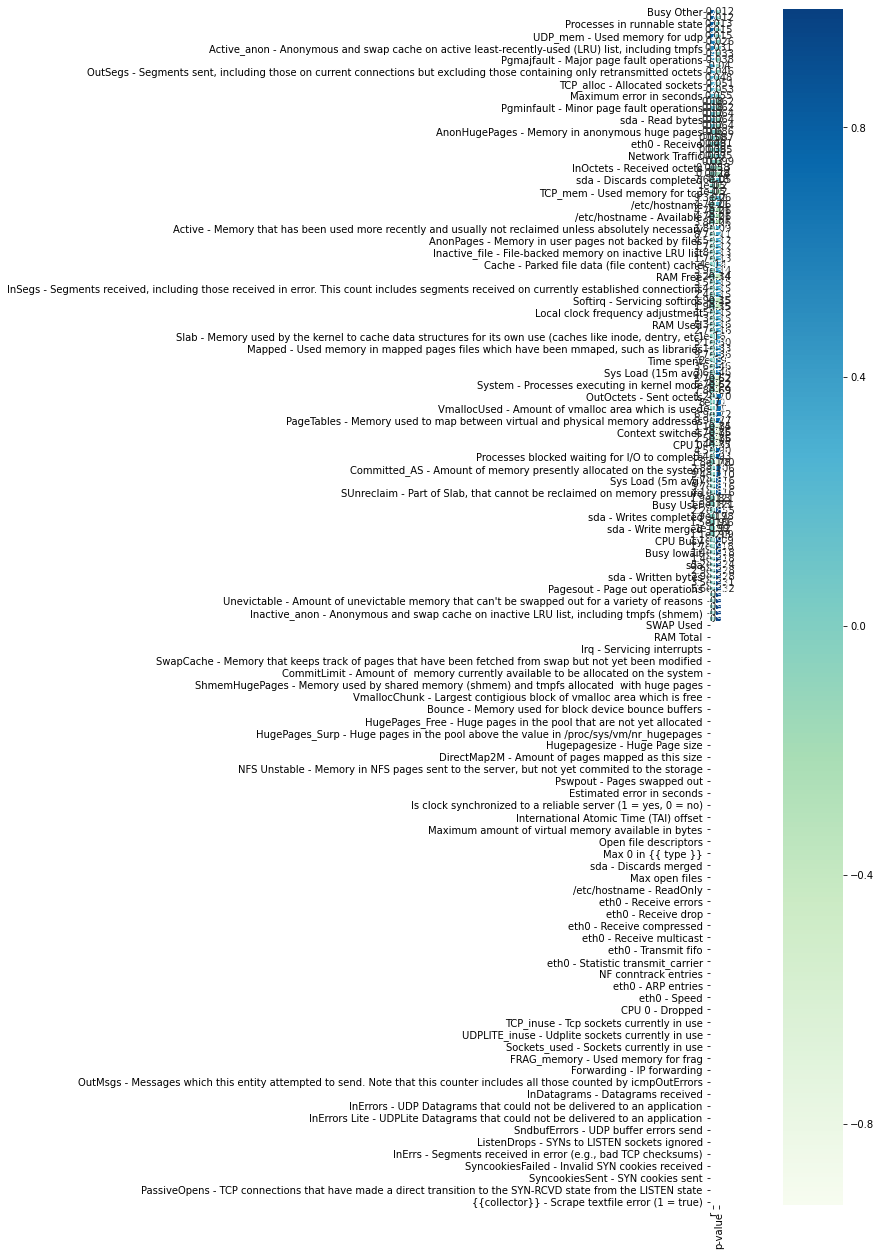

In [7]:
from scipy import stats
import pprint

correlation_txn_falure_bool = {}
for label in labels_to_correlate.columns:
    r,p = stats.pointbiserialr(labels_to_correlate[label], label_data.label)
    correlation_txn_falure_bool[label] = (p,r)
pointbiserialr = pd.DataFrame.from_dict(correlation_txn_falure_bool, orient='index').rename(columns={0:'r', 1:'p-value'}).sort_values('r', ascending=False)

print(pointbiserialr.head())
plt.figure(figsize=(22,22))
sns.heatmap(pointbiserialr, cmap='GnBu', square=True, annot=True, linewidths=.5)

<AxesSubplot:>

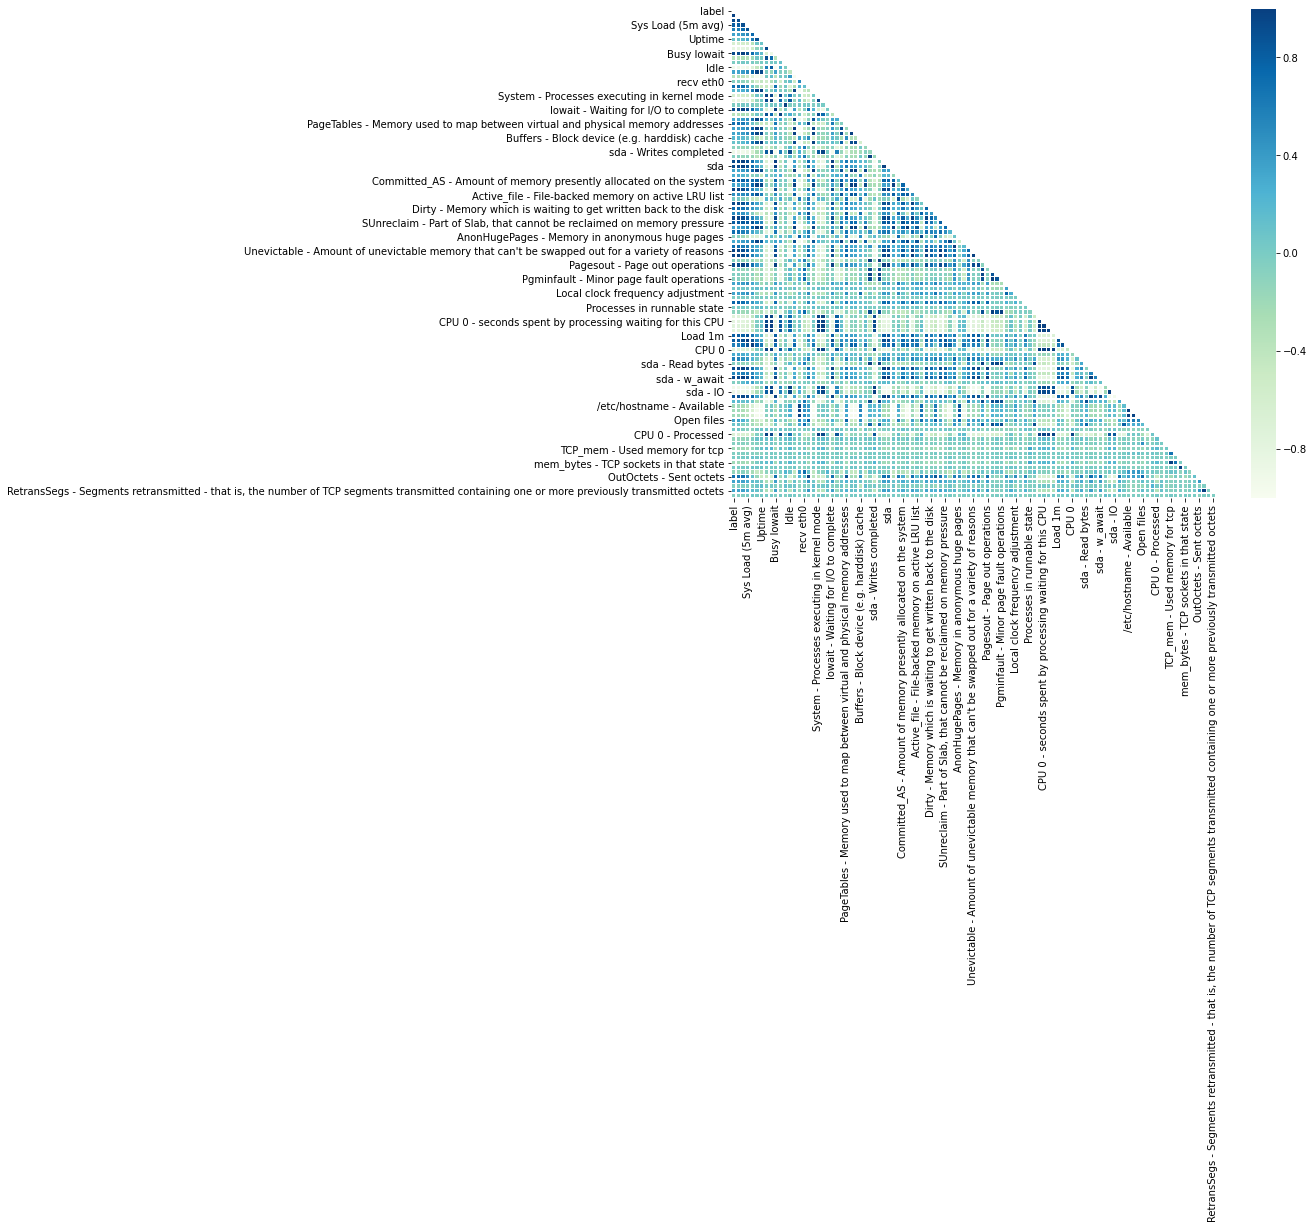

In [8]:
correlations = label_data.corr().dropna(axis=1, how='all').T.dropna(axis=1, how='all').T
# heatmap

matrix = np.triu(correlations)

plt.figure(figsize=(11,9))
sns.heatmap(correlations, cmap='GnBu', square=True, annot=False, linewidths=.5, mask=matrix)
#plt.savefig('xx.png')

In [9]:
# drop unkonwn metrics looks like those are duplicates
df_index = list(txn_falure_correlation.index)

# drop Nan
txn_falure_correlation = txn_falure_correlation.dropna(axis='rows')
txn_falure_correlation

,r,p-value
txn_fail_num,0.990535,0.000000e+00
Unevictable - Amount of unevictable memory that can't be swapped out for a variety of reasons,0.983371,0.000000e+00
MLocked - Size of pages locked to memory using the mlock() system call,0.983371,0.000000e+00
"Inactive_anon - Anonymous and swap cache on inactive LRU list, including tmpfs (shmem)",0.983216,0.000000e+00
"Shmem - Used shared memory (shared between several processes, thus including RAM disks)",0.983216,0.000000e+00
...,...,...
Busy User,-0.827565,1.938071e-121
sda - Writes completed,-0.904653,1.892855e-178
sda - IO,-0.912196,1.456549e-186
sda - Write merged,-0.923126,1.016882e-199


In [10]:
selected_features = txn_falure_correlation[np.abs(txn_falure_correlation.r) >0.5]
selected_features = selected_features[selected_features['p-value'] < 0.05]
selected_features = selected_features.drop('txn_fail_num')
selected_features_names = selected_features.index


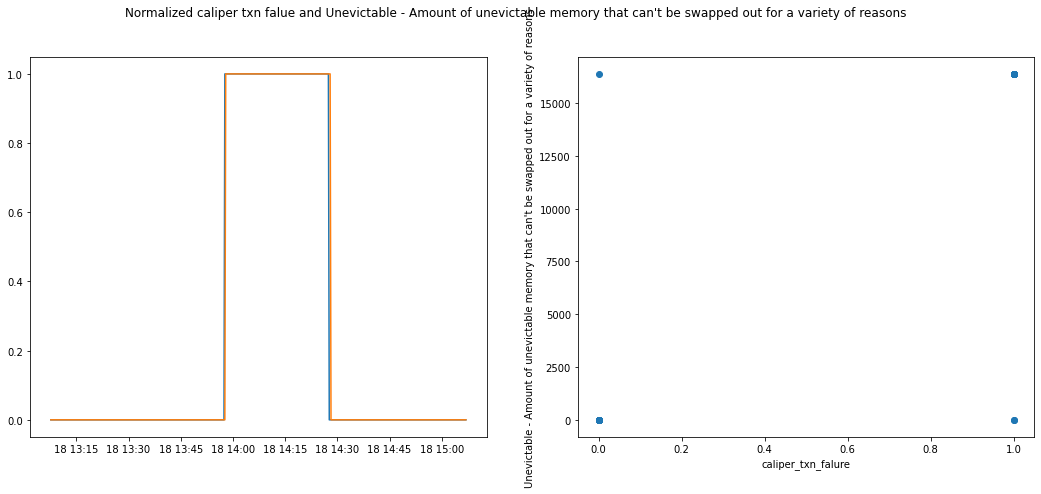

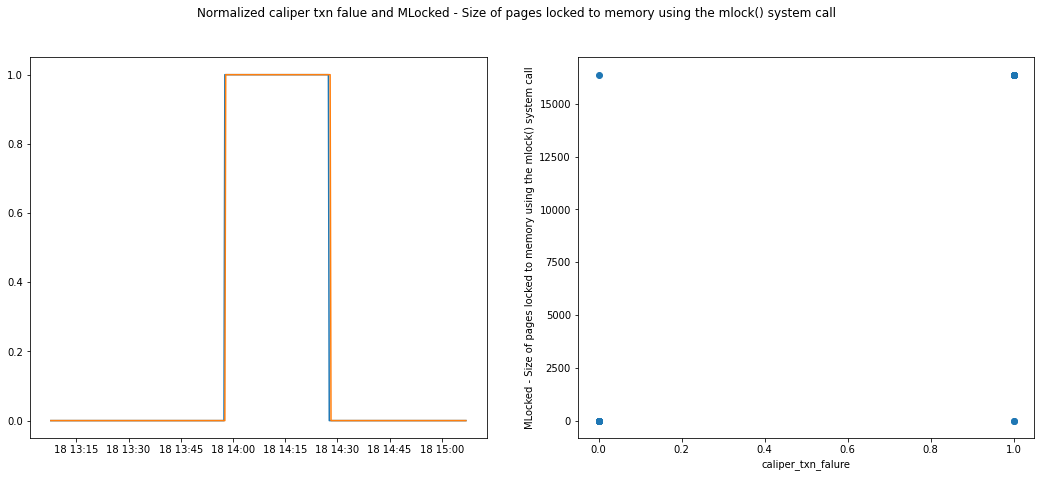

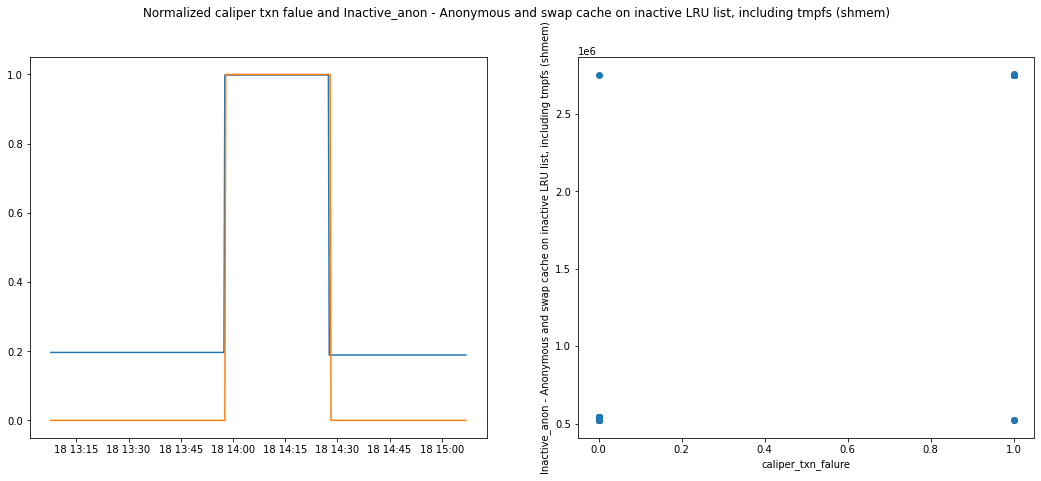

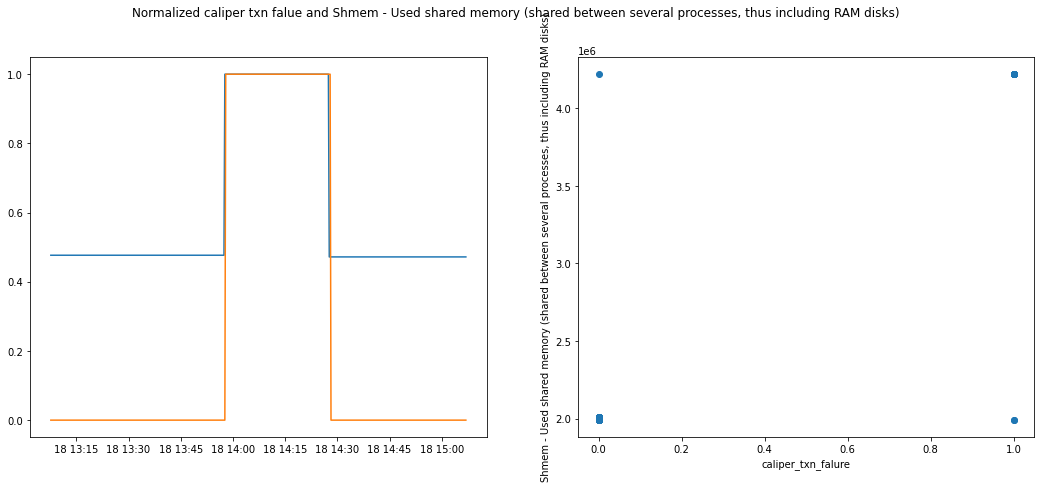

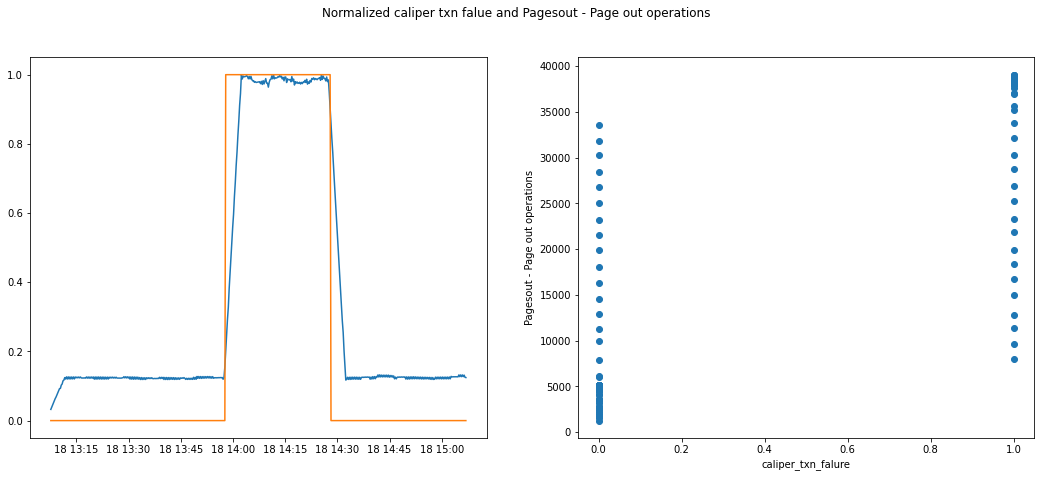

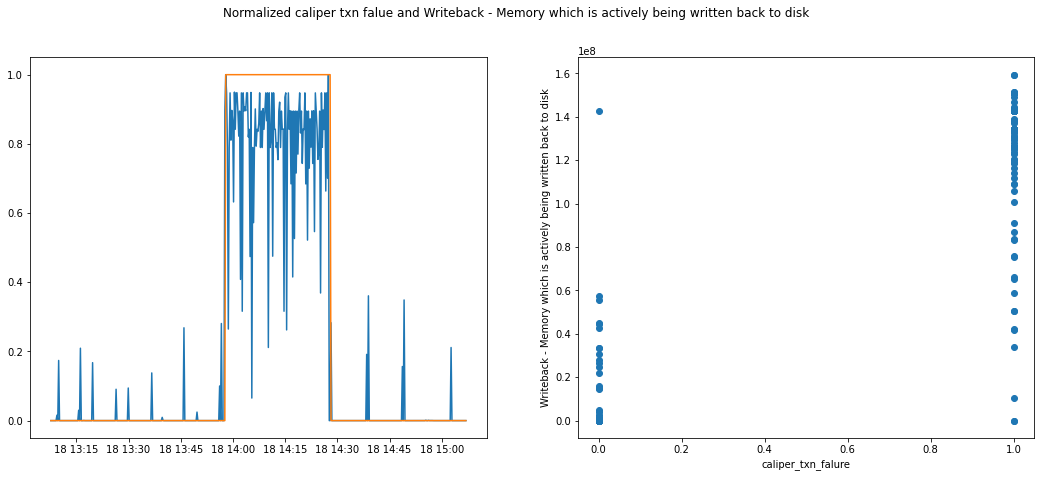

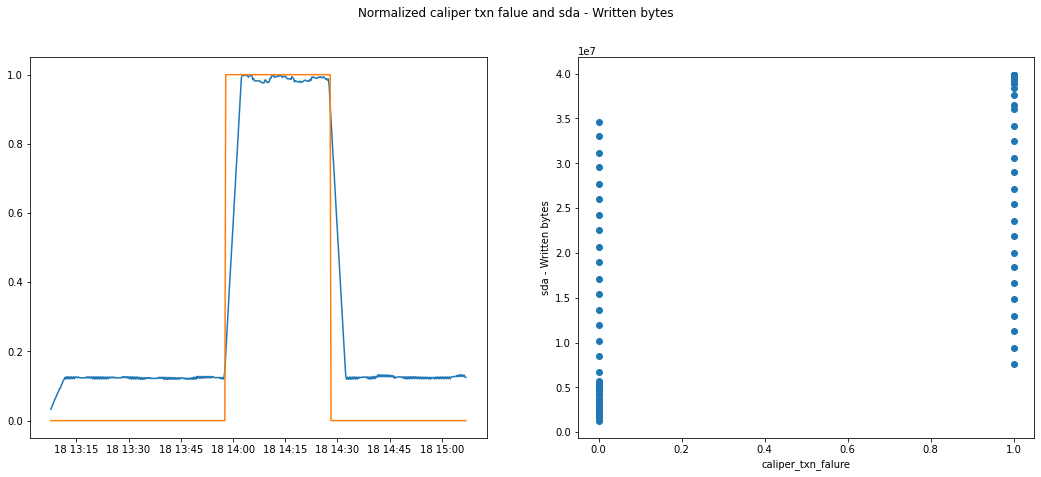

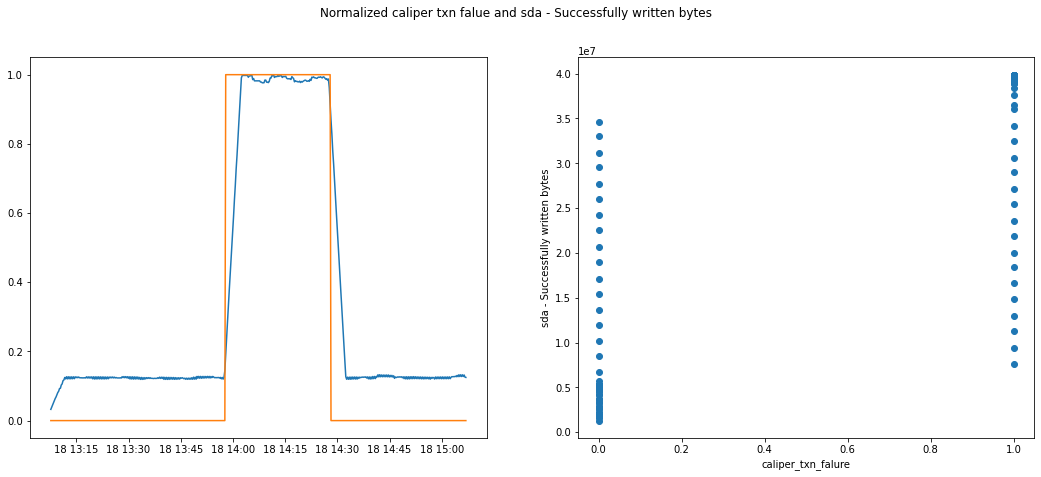

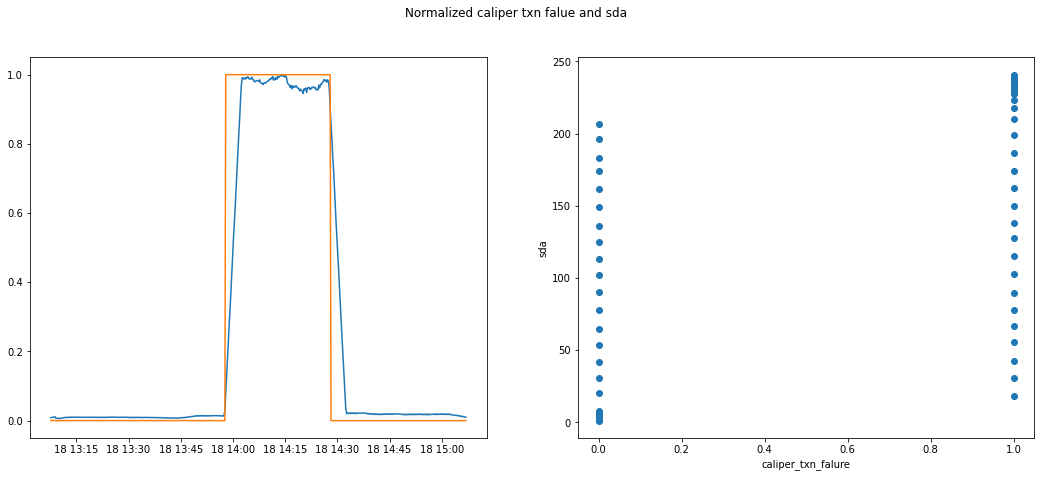

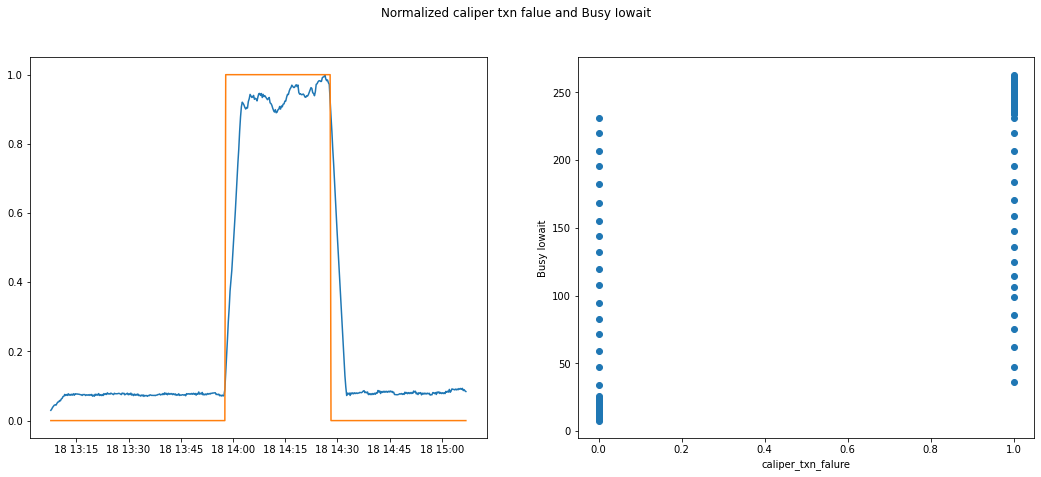

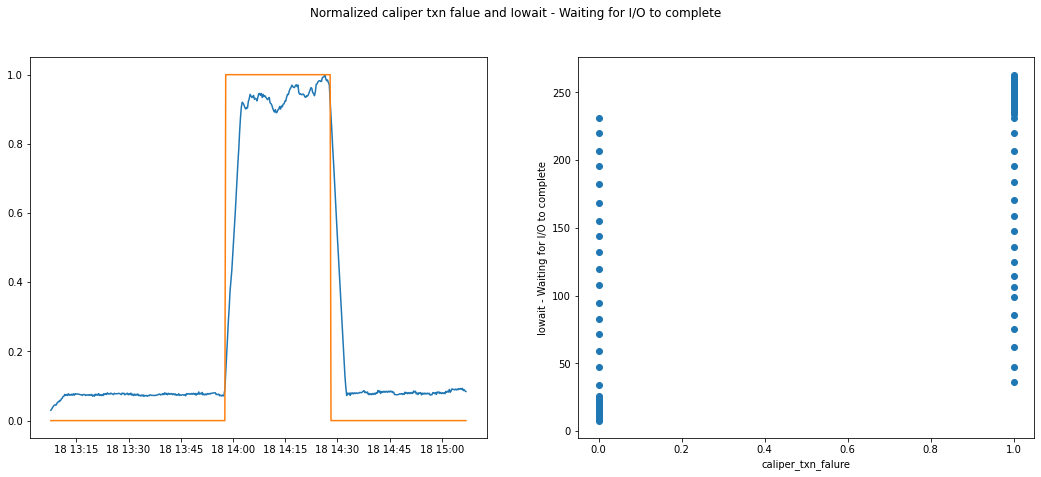

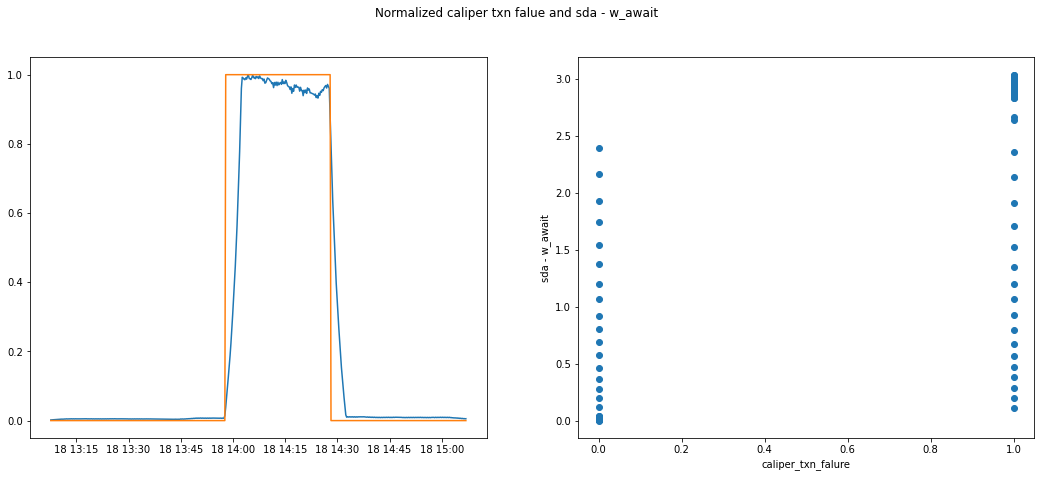

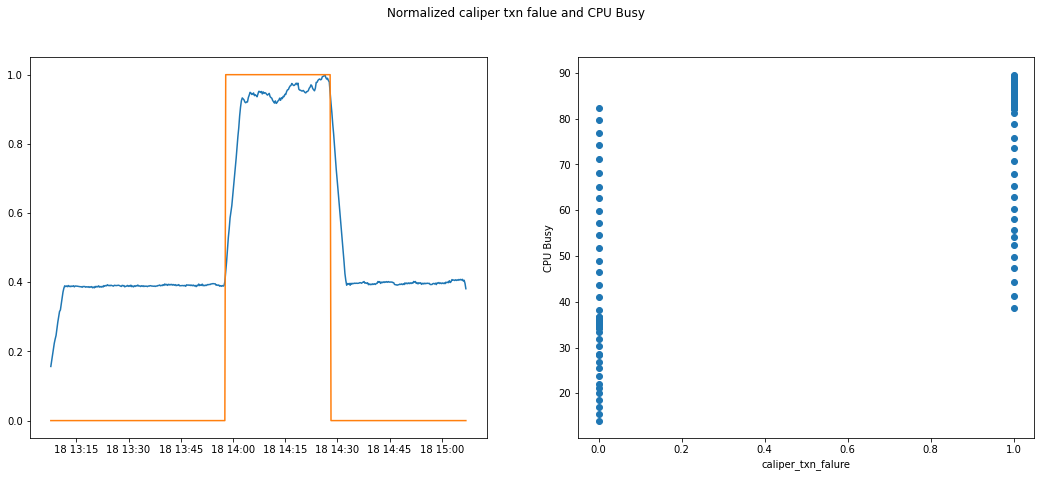

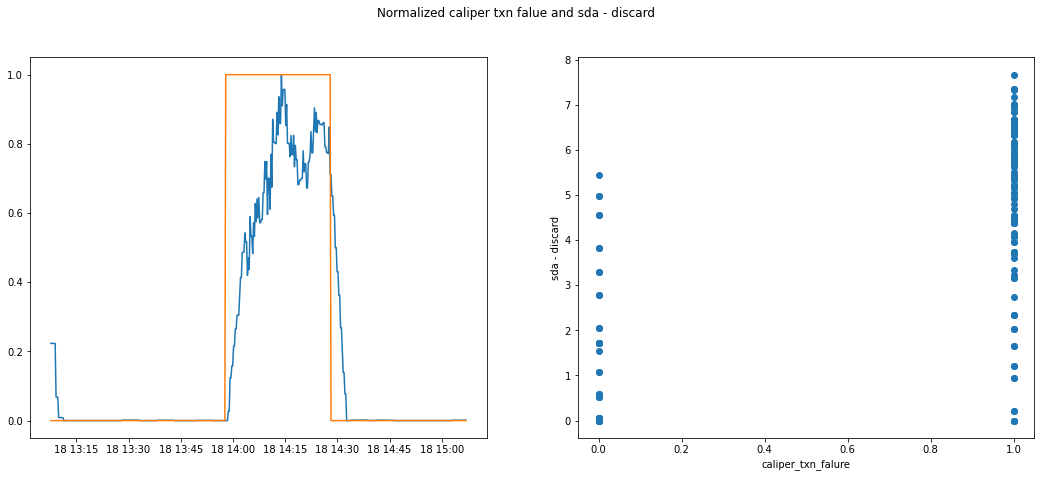

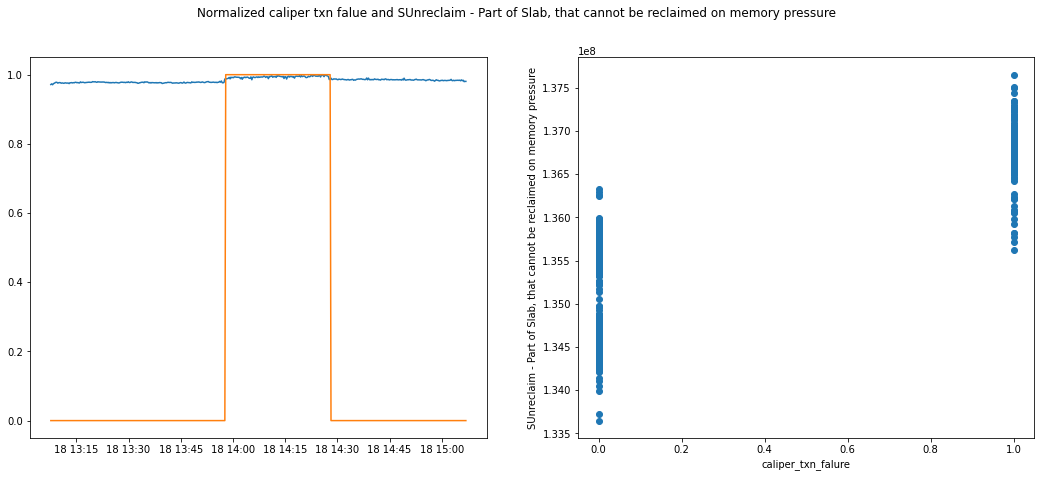

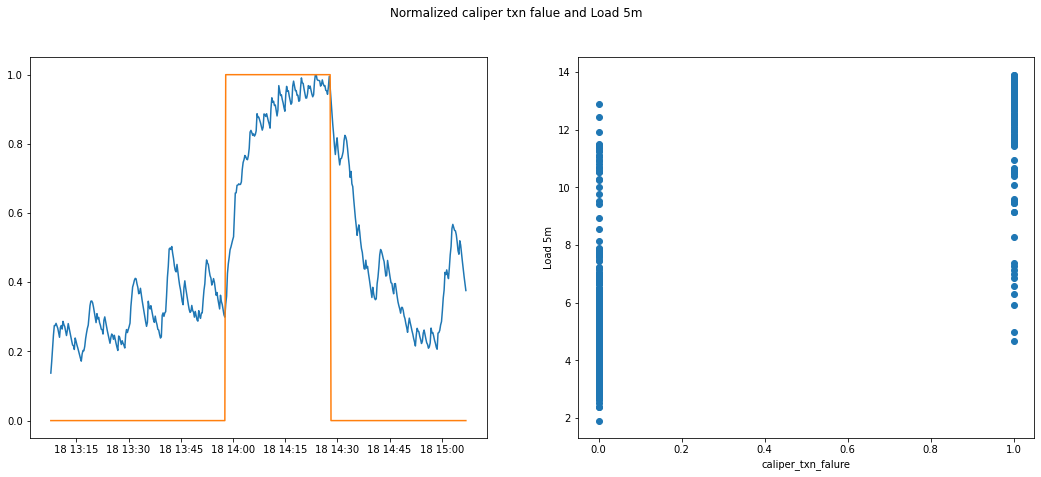

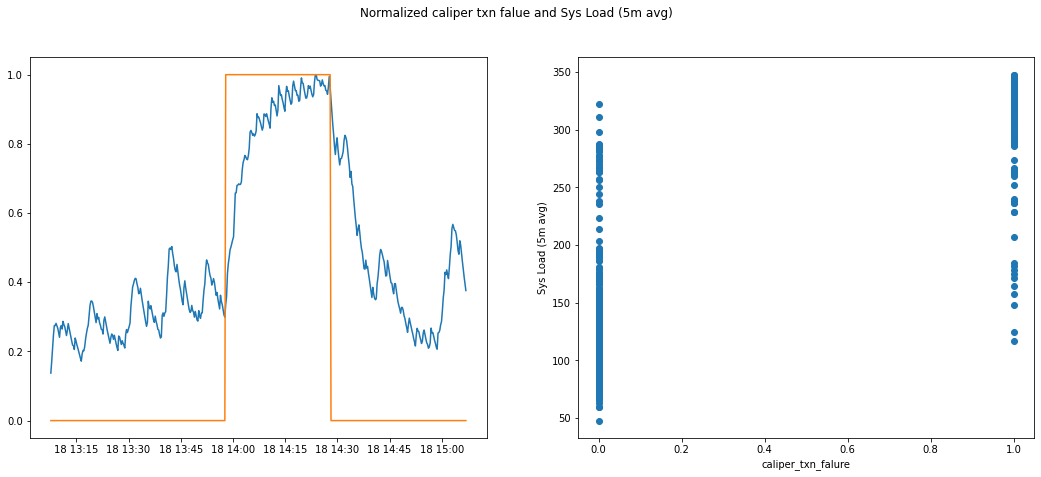

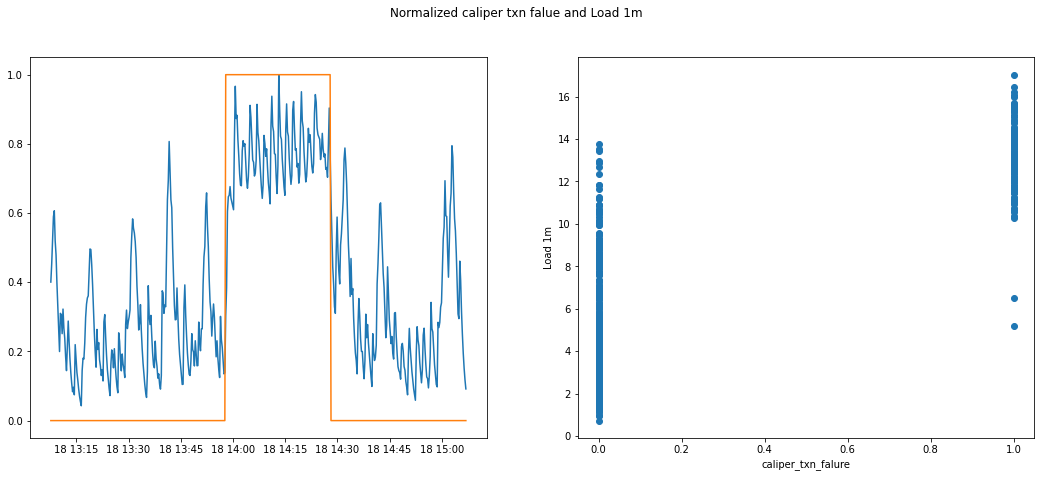

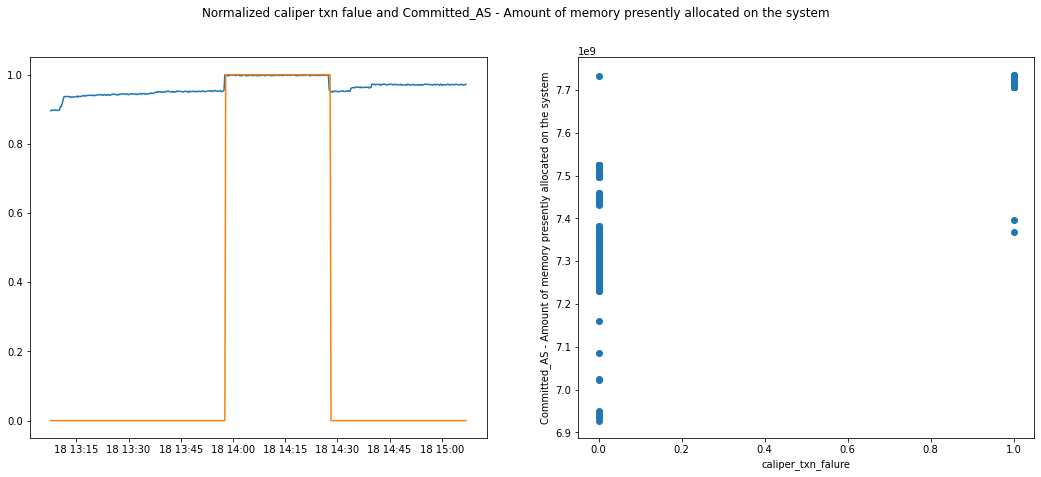

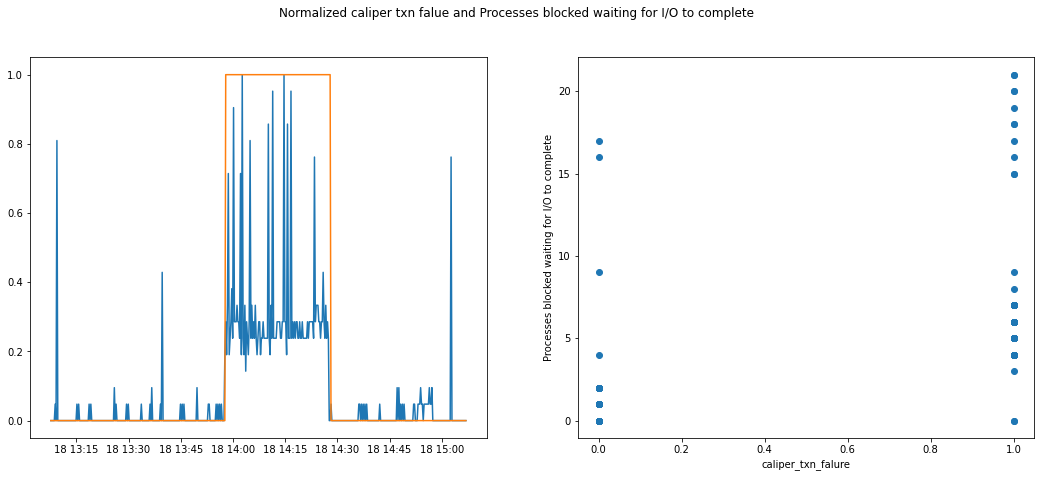

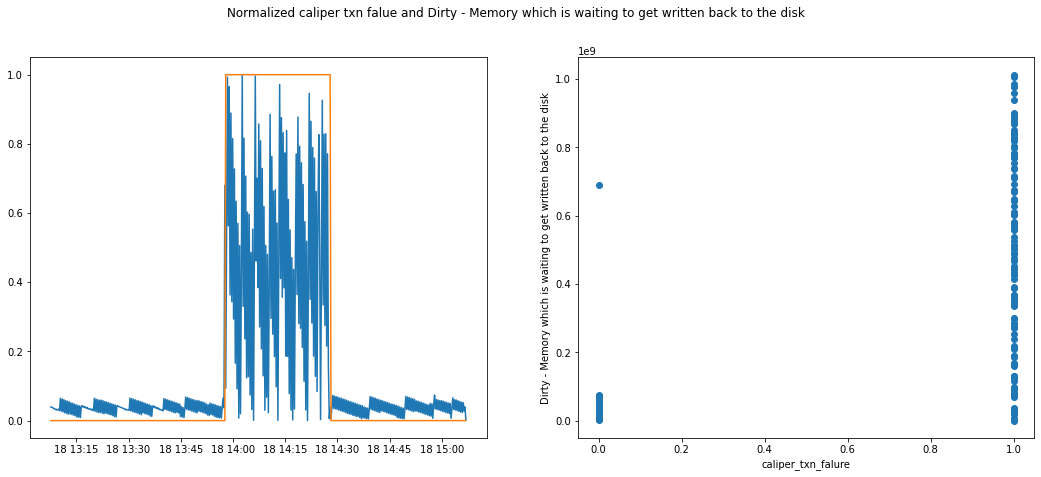

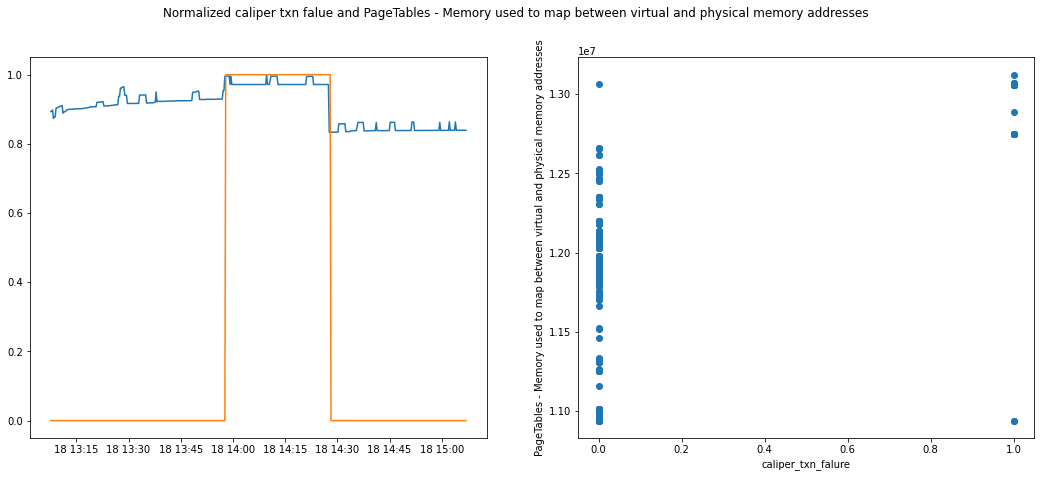

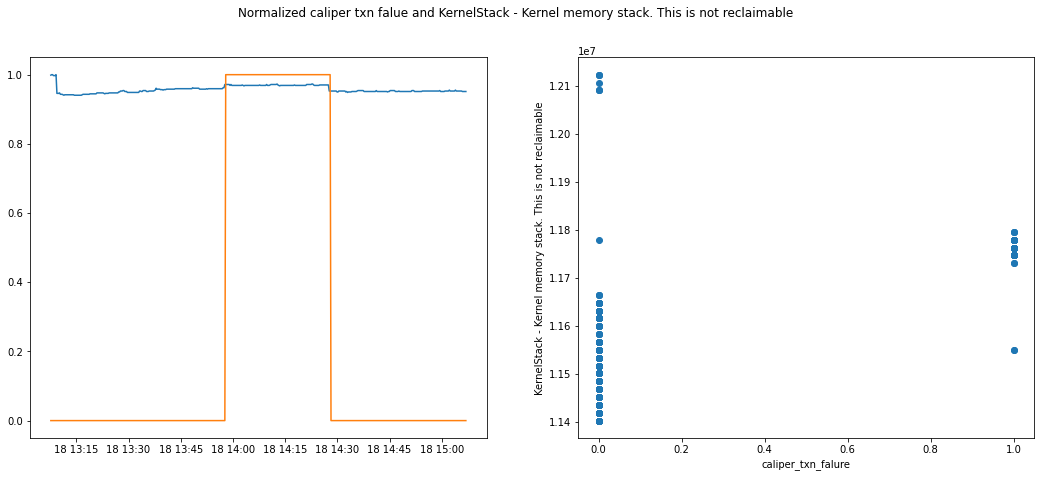

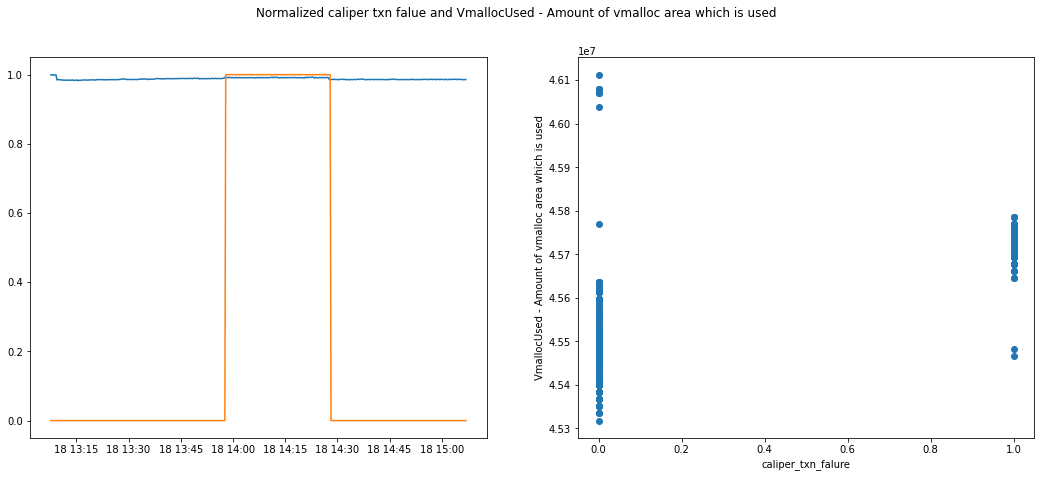

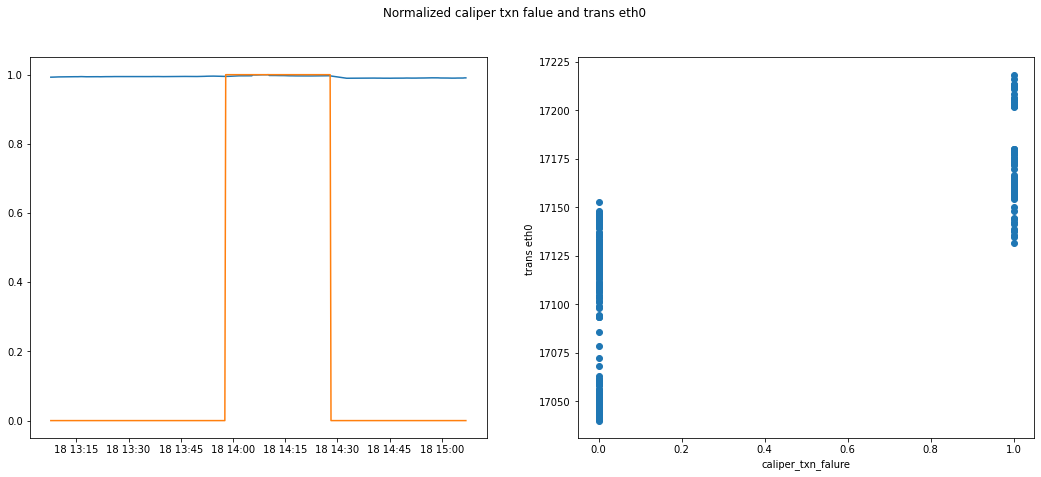

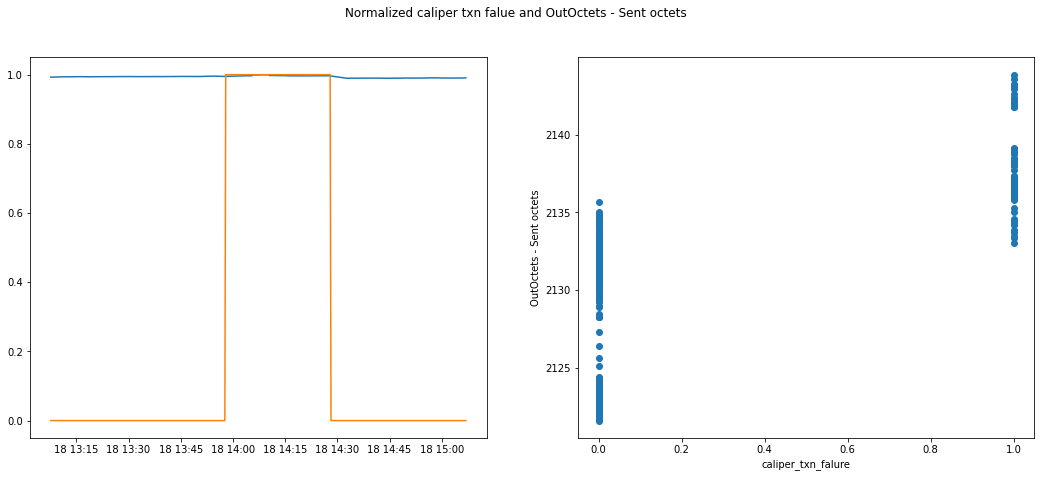

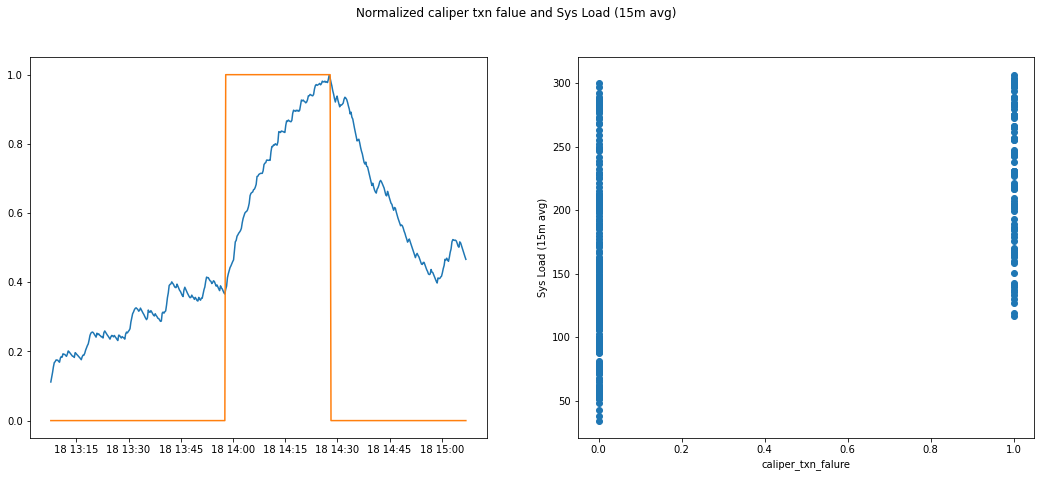

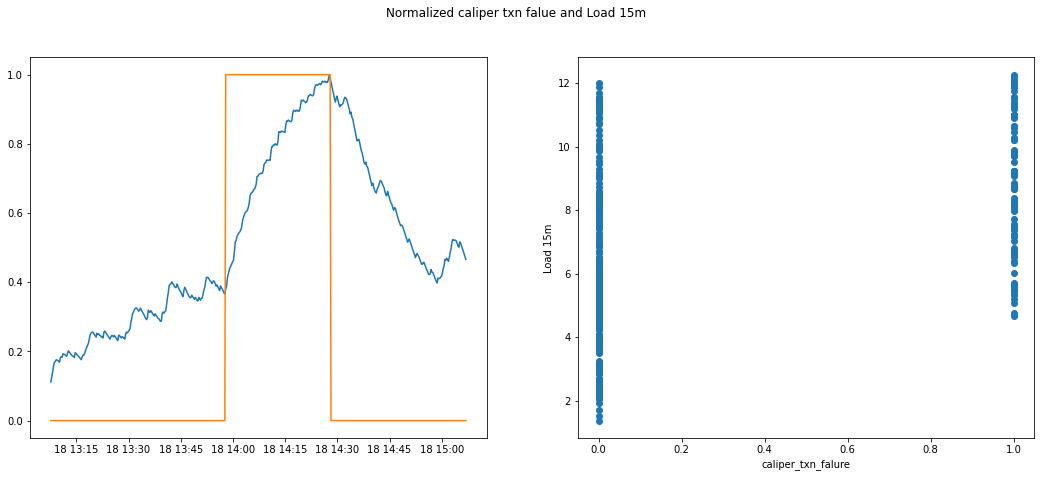

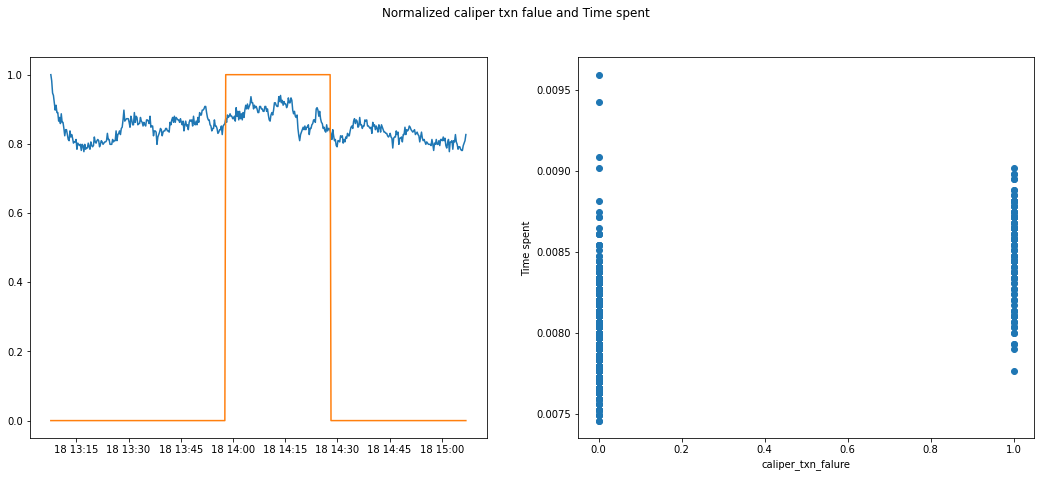

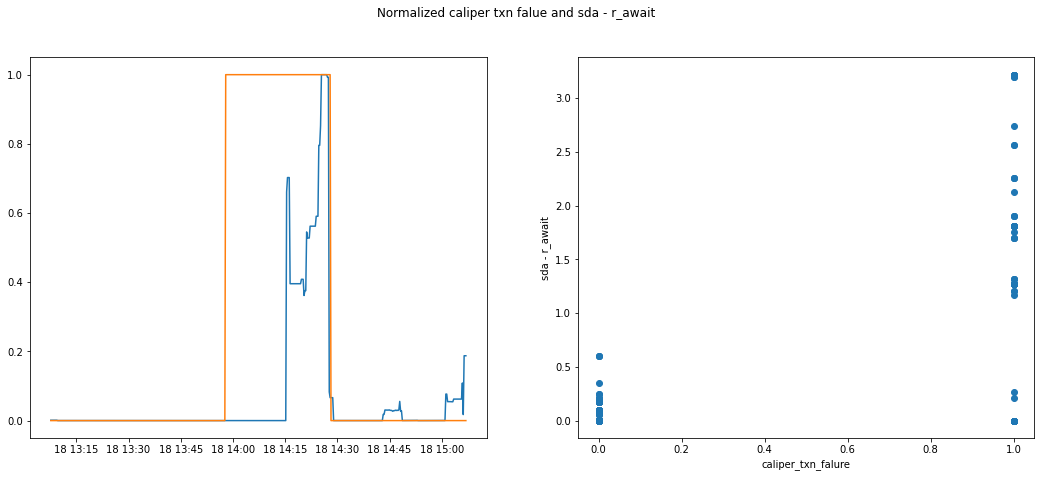

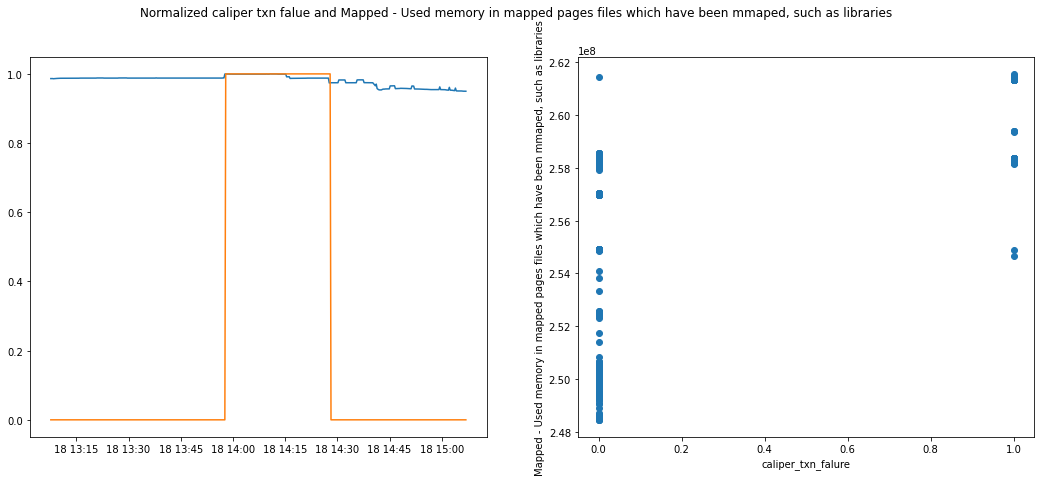

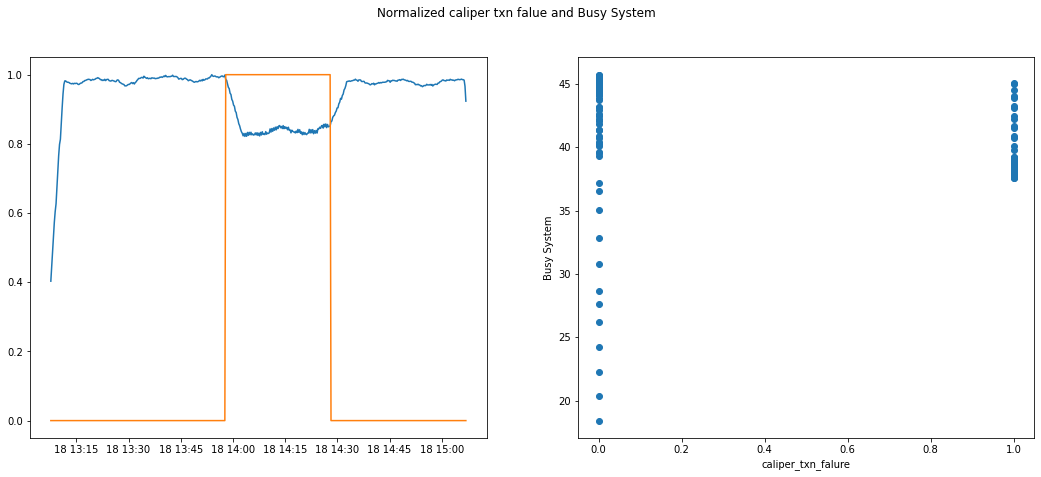

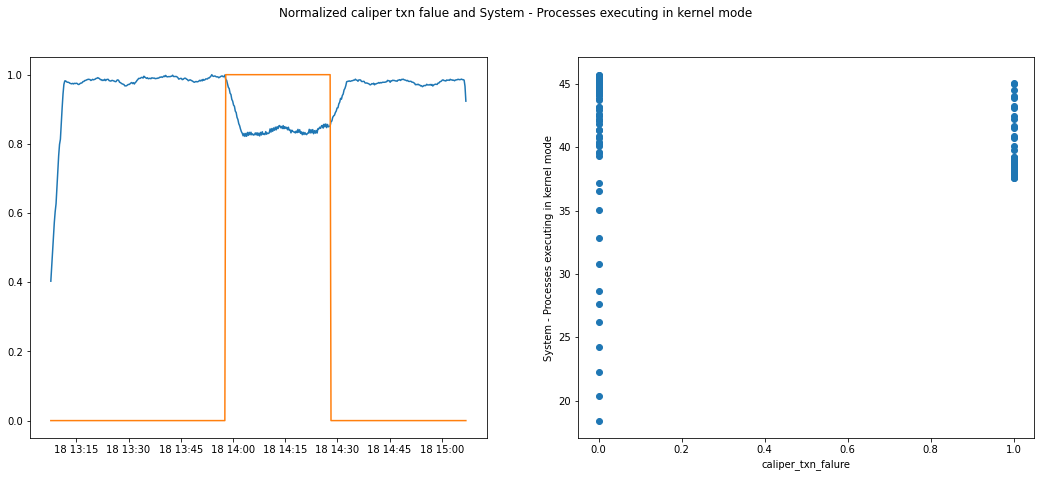

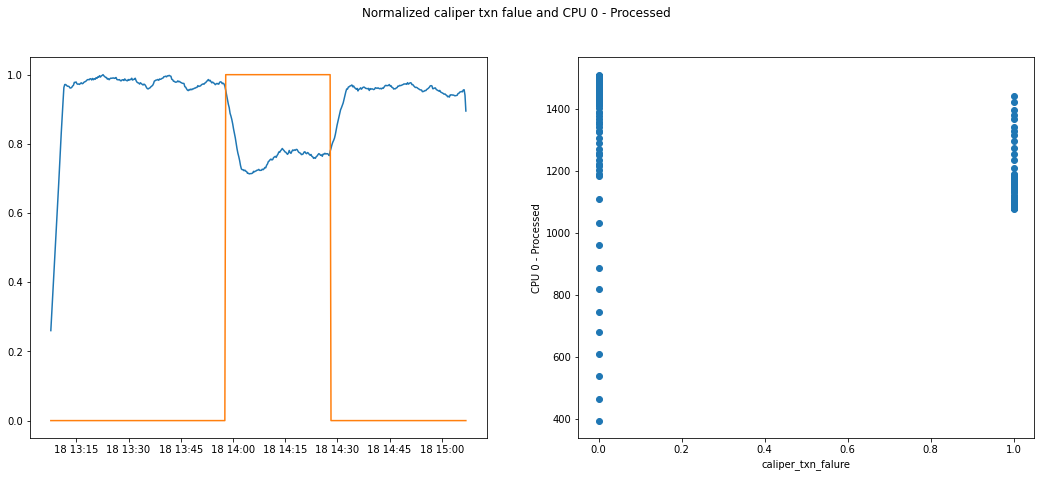

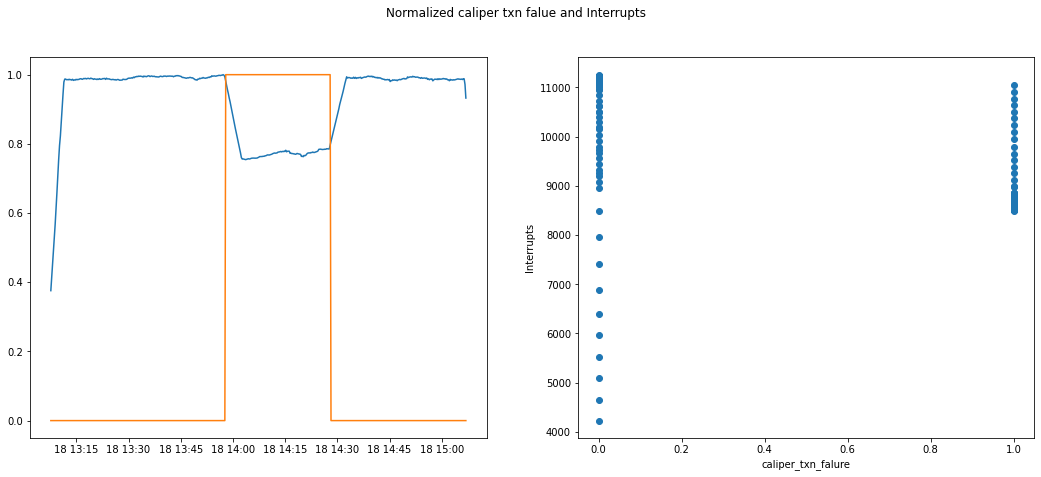

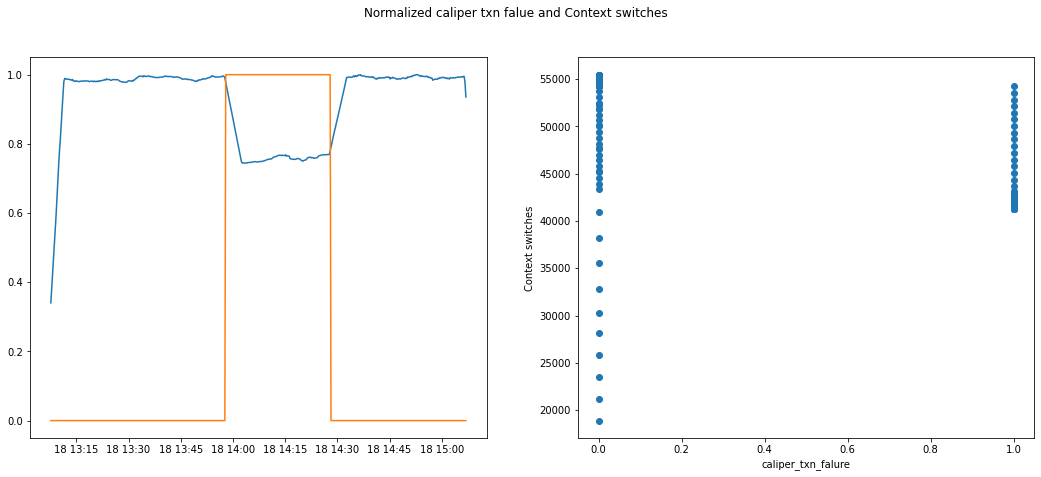

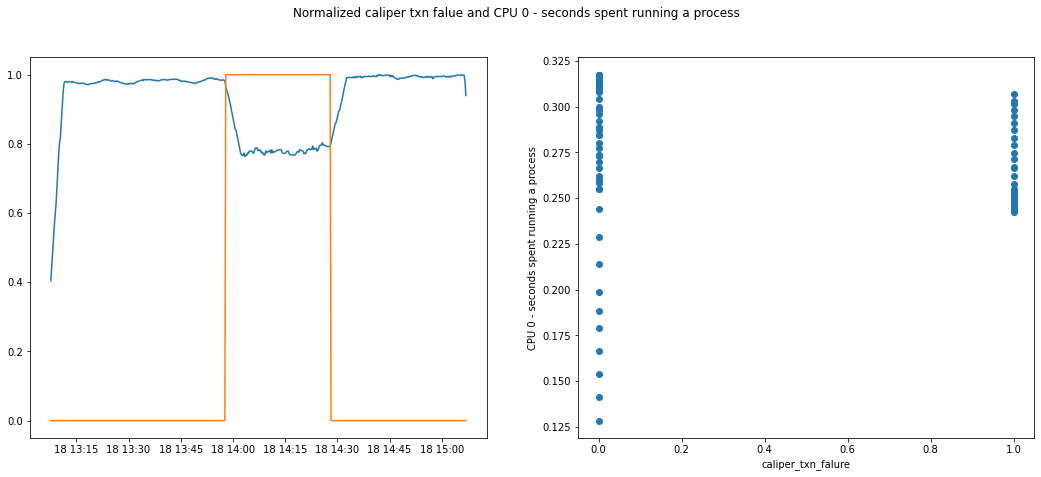

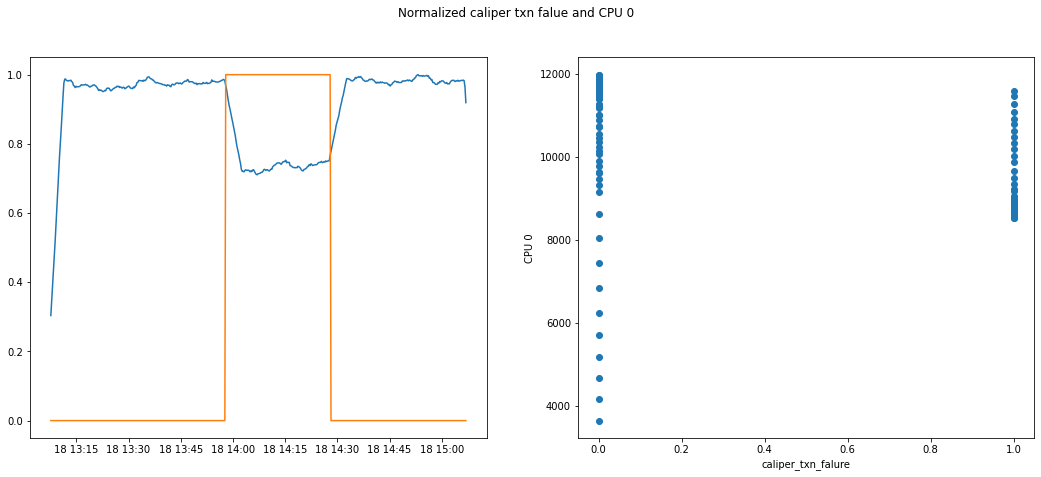

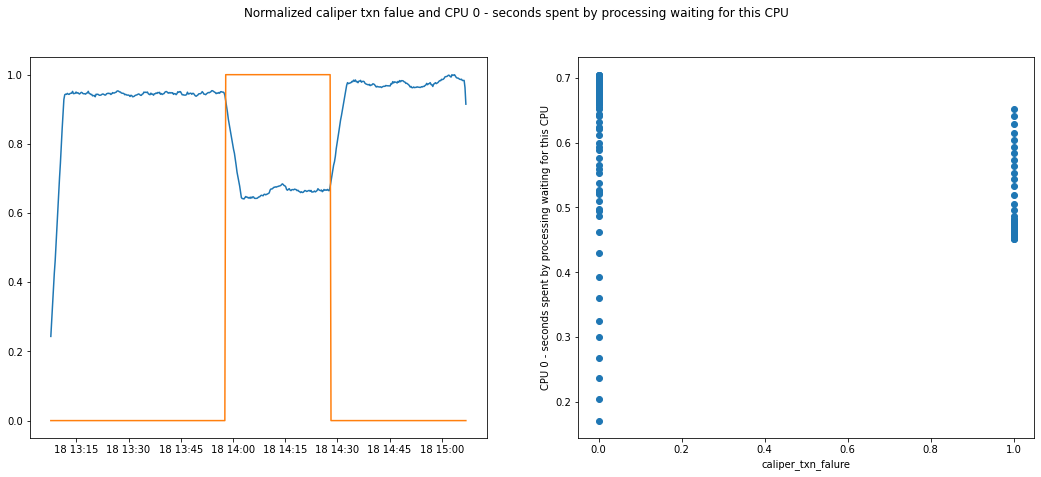

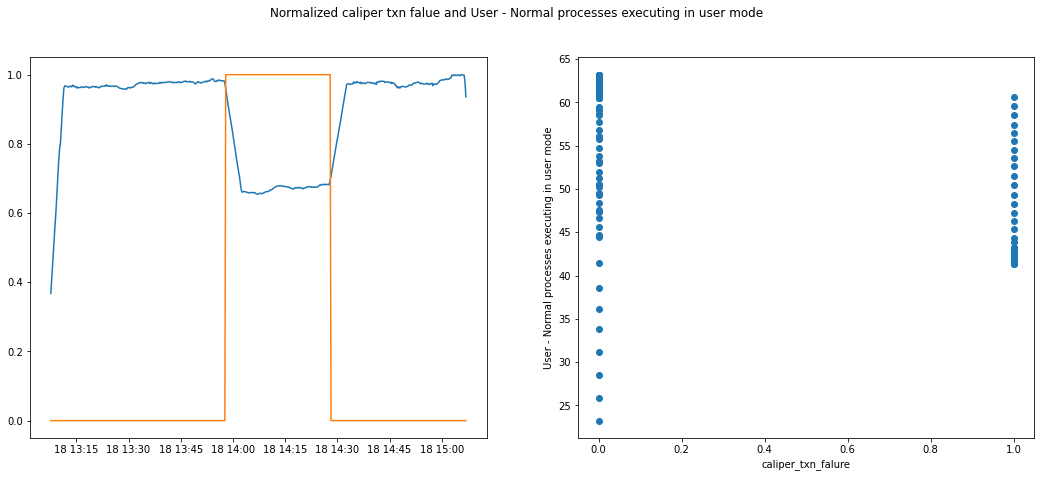

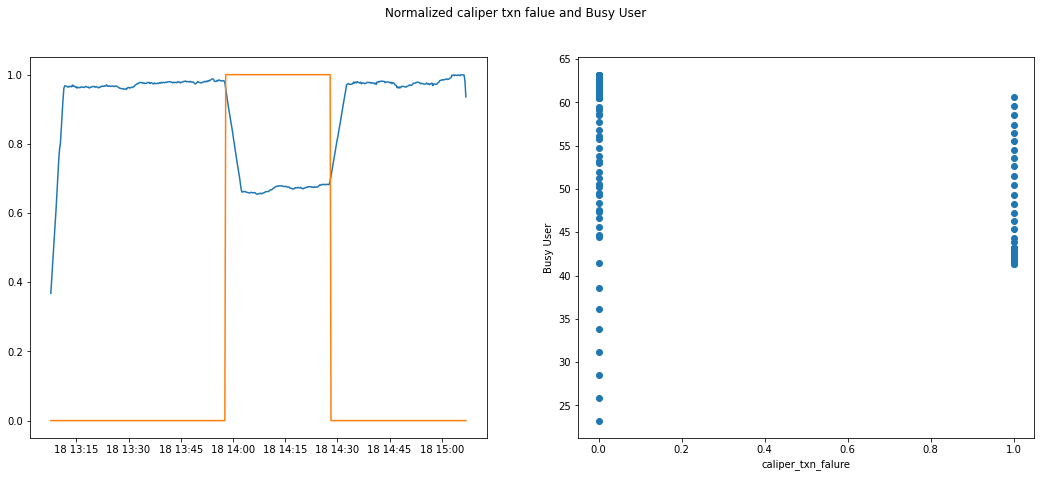

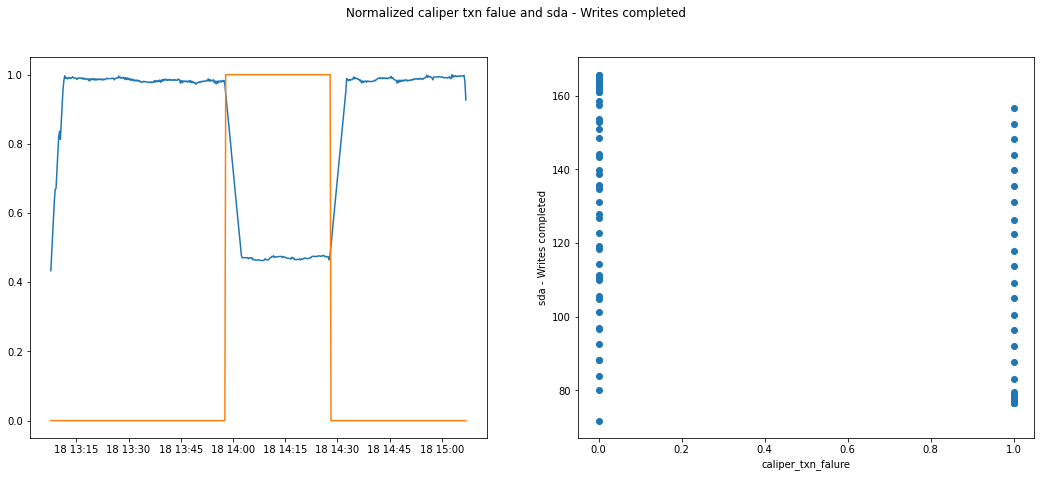

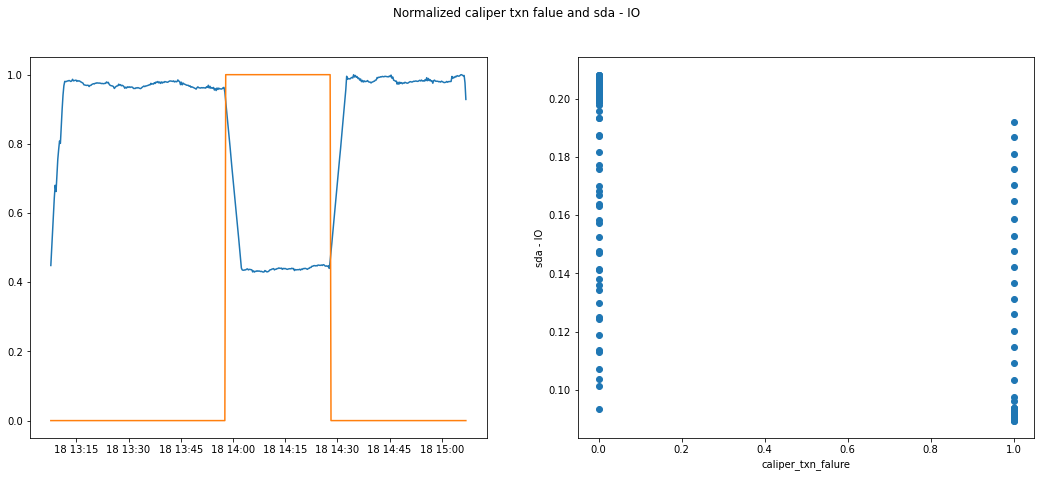

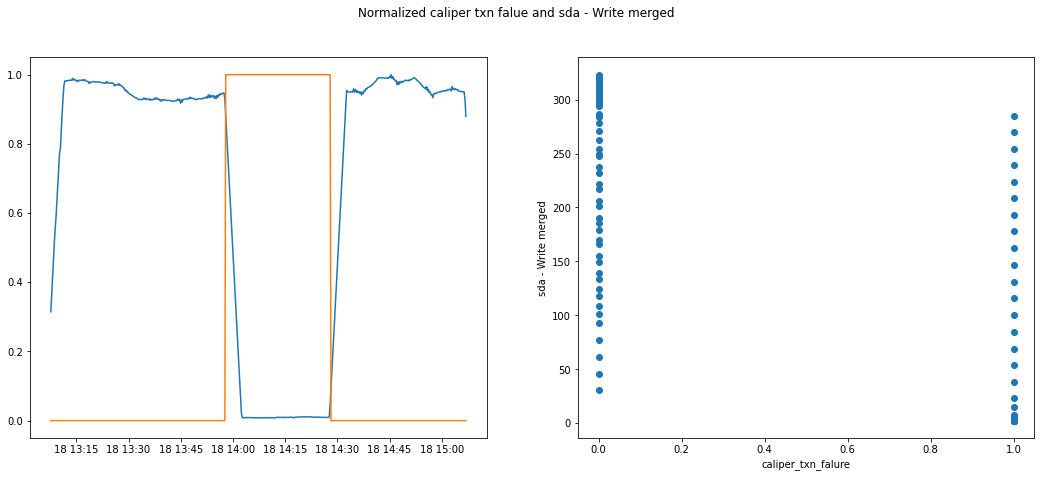

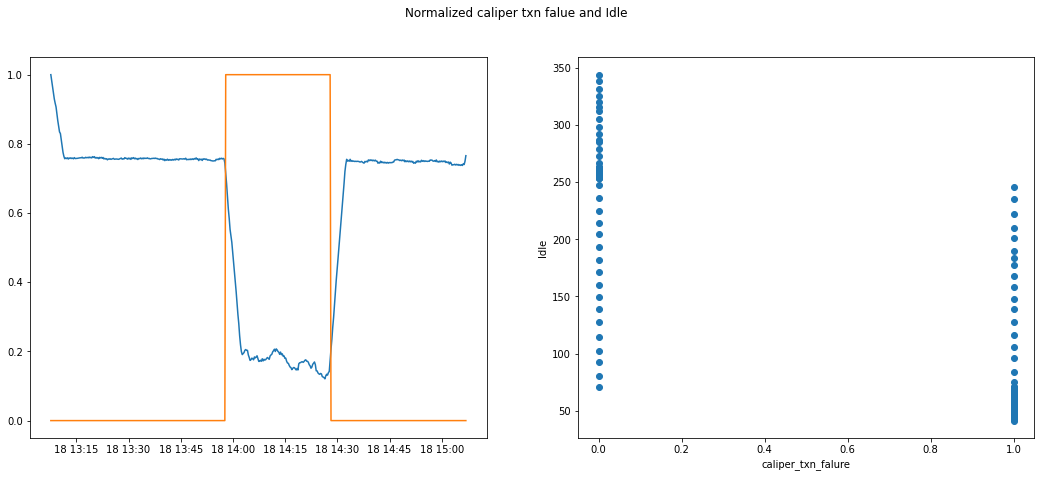

In [11]:
from sklearn.preprocessing import MinMaxScaler
normalized_label_data = label_data.copy()

for i in normalized_label_data.drop(['time'], axis=1).columns:  
    normalized_label_data[i]/=normalized_label_data[i].max()

# Old method use all selected features separately
for feature in selected_features_names:
    fig, ax =plt.subplots(figsize=(18,7))
    
    plt.subplot(1,2,1)
    plt.plot(normalized_label_data['time'], normalized_label_data[feature], label=feature)
    plt.plot(normalized_label_data['time'],normalized_label_data['label'],label='caliper_txn_falue')
    
    plt.subplot(1,2,2)
    plt.suptitle("Normalized caliper txn falue and "+feature)
    plt.scatter(label_data['label'], label_data[feature])
    plt.xlabel('caliper_txn_falure')
    plt.ylabel(feature)
    plt.show()

# PCA

In [12]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

all_metrics = label_data.drop(['time', 'label', "txn_fail_num"], axis = 1).columns

scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(label_data[all_metrics])


# How to justify components?
pca = PCA(n_components = 0.95)
pca_df = pca.fit_transform(scaled_df)
pca.fit(label_data.drop(['time', 'label'], axis=1))

print(pca.explained_variance_ratio_)
print(pca.singular_values_)


[0.98596294]
[2.65104904e+11]


# DBscan

In [13]:
NUMBER_OF_EXPERIMENTS = 1000

In [96]:
from sklearn.cluster import DBSCAN


def evaluate(y_real, y_pred):
    accuracy = accuracy_score(y_real,y_pred)
    precision = precision_score(y_real, y_pred, average='macro')
    recall = metrics.recall_score(y_real, y_pred, average='macro')
    f1_score = metrics.f1_score(y_real, y_pred, average='macro') 
    
    # AUC curve
    fpr, tpr, threshold = metrics.roc_curve(y_real, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    return accuracy, precision, recall, f1_score, fpr, tpr, roc_auc

# since boolean predictions may be wrong way around
def result(y_real, y_pred):
    if  metrics.f1_score(y_real, y_pred, average='macro') >  metrics.f1_score(y_real, [not y for y in y_pred], average='macro'):
        return evaluate(y_real, y_pred)
    else:
        return evaluate(y_real, [not y for y in y_pred])

def show_res(res):
    accuracy, precision, recall, f1_score,fpr, tpr, roc_auc, time = res
    print("Accuracy", accuracy)
    print("Precision", precision)
    print("Recall", recall)
    print("F1 Score", f1_score)
    print("Time", time)
    
    plt.figure(figsize=(6,6))
    plt.title('Validation ROC')
    plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.3f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [15]:
def dbscan_predictions(df, n):
    accuracy_, precision_, recall_, f1_score_,fpr_, tpr_, roc_auc_, time_ = [],[],[],[],[], [],[],[]
    for i in range(n):
        X_train, X_test, Y_train, Y_test = train_test_split(df, label_data.label, test_size=0.4, random_state=22)
        
        start_time = time.time()
        clustering = DBSCAN(eps=3, min_samples=2).fit(df)

        y_pred = clustering.fit_predict(X_test)
        accuracy, precision, recall, f1_score, fpr, tpr, roc_auc = result(Y_test, y_pred)
        end_time = time.time()
        fpr_.append(fpr)
        tpr_.append(tpr)
        
        accuracy_.append(accuracy)
        precision_.append(precision)
        recall_.append(recall)
        f1_score_.append(f1_score)
        roc_auc_.append(roc_auc)
        time_.append(end_time - start_time)
    return np.mean(accuracy_), np.mean(precision_), np.mean(recall_), np.mean(f1_score_), np.average(fpr_, axis=0), np.average(tpr_, axis=0), np.mean(roc_auc_), np.mean(time_)

All metrics
Accuracy 0.7760416666666665
Precision 0.38802083333333326
Recall 0.5
F1 Score 0.4369501466275658
F1 Score 0.03999902367591858


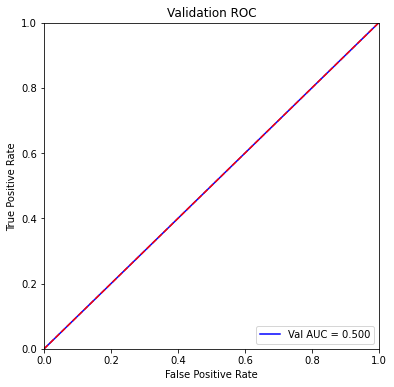

Correlation metrics
Accuracy 0.7760416666666665
Precision 0.38802083333333326
Recall 0.5
F1 Score 0.4369501466275658
F1 Score 0.03536526799201965


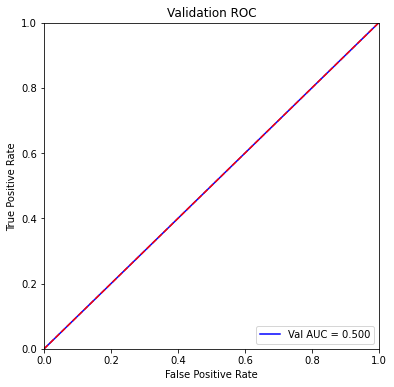

All metrics
Accuracy 0.7604166666666665
Precision 0.3862433862433861
Recall 0.4899328859060404
F1 Score 0.4319526627218935
F1 Score 0.011303352355957032


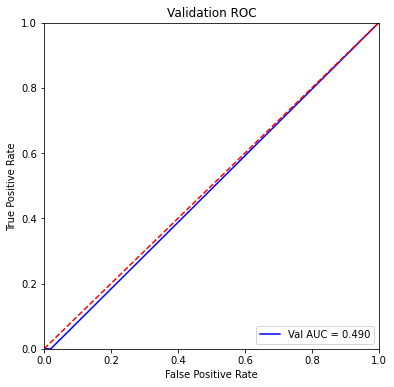

In [16]:
print("All metrics")
show_res(dbscan_predictions(label_data.drop(['label', 'time', 'txn_fail_num'],axis=1), NUMBER_OF_EXPERIMENTS))

print("Correlation metrics")
show_res(dbscan_predictions(label_data.drop(['label', 'time', 'txn_fail_num'],axis=1)[selected_features_names], NUMBER_OF_EXPERIMENTS))

print("All metrics")
show_res(dbscan_predictions(pca_df,NUMBER_OF_EXPERIMENTS))

# Isolation Forest

In [17]:
#New method combine all selected features

from sklearn.ensemble import IsolationForest
clf=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.12), \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)


def isolation_forest_(df):
    clf.fit(df)
    pred = clf.predict(df)
    test_df=pd.DataFrame()
#     Find decision function to find the score and classify anomalies
    test_df['score']=clf.decision_function(df)
    # test_df['actuals']=metrics_df[list(all_metrics)]
    test_df['anomaly']=pred

    # Get the indexes of outliers in order to compare the metrics     with use case anomalies if required
    outliers=test_df.loc[test_df['anomaly']==-1]
    outlier_index=list(outliers.index)

    # test_df=classify_anomalies(test_df,metrics_df.columns[i])
    # plot_anomaly(test_df,metrics_df.columns[i])

    for i,j in enumerate(pred):
        if j == -1:
            pred[i] = 0
    return pred

# def evaluate(y_real, y_pred, method):
#     accuracy = accuracy_score(y_real,y_pred)
#     # invert labels if predictions wrong way around
    
#     print(method)
#     print('Accuracy: ', accuracy)
#     # precision
#     precision = precision_score(y_real, y_pred, average='macro')
#     print('Precision: ', precision)
#     # recall
#     recall = metrics.recall_score(y_real, y_pred, average='macro')
#     print('Recall: ', recall)
#     f1_score = metrics.f1_score(y_real, y_pred, average='macro') 
#     print('F1 score: ', f1_score)
    
#     # AUC curve
#     fpr, tpr, threshold = metrics.roc_curve(y_real, y_pred)
#     roc_auc = metrics.auc(fpr, tpr)
#     plt.figure(figsize=(6,6))
#     plt.title('Validation ROC')
#     plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.3f' % roc_auc)
#     plt.legend(loc = 'lower right')
#     plt.plot([0, 1], [0, 1],'r--')
#     plt.xlim([0, 1])
#     plt.ylim([0, 1])
#     plt.ylabel('True Positive Rate')
#     plt.xlabel('False Positive Rate')
#     plt.show()



In [18]:
# X_train, X_test, Y_train, Y_test = train_test_split(label_data.drop(['label', 'time', 'txn_fail_num'],axis=1)\
#                                                     , label_data.label, test_size=0.2, random_state=22)

# X_pca_train, X_pca_test, Y_pca_train, Y_pca_test = train_test_split(pca_df, label_data.label, test_size=0.2,\
#                                                                             random_state=22)
from statistics import mean
def pca_predictions(df, n):
    accuracy_, precision_, recall_, f1_score_,fpr_, tpr_, roc_auc_, time_ = [],[],[],[],[], [],[],[]
    for i in range(n):
        X_train, X_test, Y_train, Y_test = train_test_split(df, label_data.label, test_size=0.4, random_state=22)
        
        start_time = time.time()
        y_pred = isolation_forest_(df)       
        accuracy, precision, recall, f1_score, fpr, tpr, roc_auc = result(label_data.label, y_pred)
        end_time = time.time()
        fpr_.append(fpr)
        tpr_.append(tpr)
        
        accuracy_.append(accuracy)
        precision_.append(precision)
        recall_.append(recall)
        f1_score_.append(f1_score)
        roc_auc_.append(roc_auc)
        time_.append(end_time - start_time)
    return np.mean(accuracy_), np.mean(precision_), np.mean(recall_), np.mean(f1_score_), np.average(fpr_, axis=0), np.average(tpr_, axis=0), np.mean(roc_auc_), np.mean(time_)

All metrics
Accuracy 0.7552301255230128
Precision 0.6600985221674877
Recall 0.5902840475032988
F1 Score 0.5978947822523242
F1 Score 0.5047458572387695


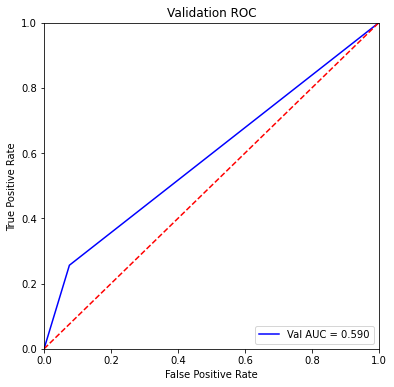

Correlation metrics
Accuracy 0.7384937238493723
Precision 0.6208538587848934
Recall 0.5681528809871056
F1 Score 0.5704004083892354
F1 Score 0.42855103039741516


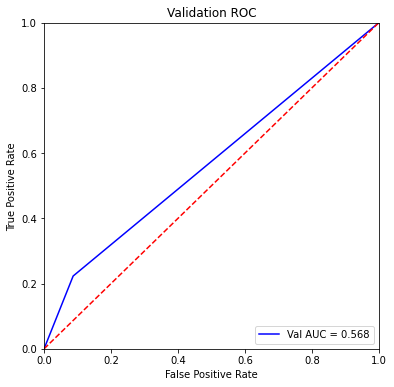

All metrics
Accuracy 0.7761506276150628
Precision 0.7091543513957307
Recall 0.6179480056485401
F1 Score 0.6322627495811854
F1 Score 0.3728197240829468


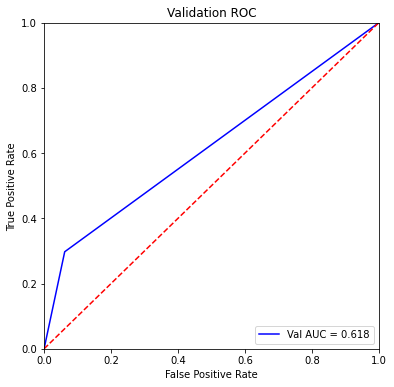

In [19]:
print("All metrics")
show_res(pca_predictions(label_data.drop(['label', 'time', 'txn_fail_num'],axis=1), NUMBER_OF_EXPERIMENTS))

print("Correlation metrics")
show_res(pca_predictions(label_data.drop(['label', 'time', 'txn_fail_num'],axis=1)[selected_features_names], NUMBER_OF_EXPERIMENTS))

print("All metrics")
show_res(pca_predictions(pca_df, NUMBER_OF_EXPERIMENTS))

# Kmeans

In [20]:
from sklearn.cluster import KMeans

    
def cluster(data):
    data = pd.DataFrame(data)
    clf = KMeans(n_clusters=2)
    clf.fit(data)
    
    # always classify anomaly as 1
    labels = clf.labels_
    one_counts = list(labels).count(1)
    zero_counts = list(labels).count(0)
    
    return labels

def plot_kmeans(df, predictions, column, plot=True):
    
#     predictions = pd.DataFrame(predictions, columns = ['predictions'])
    df_copy = df.copy()
    df_copy['predictions'] = predictions
    
    if not plot:
        return df_copy

    fig, ax = plt.subplots(figsize=(10,6))
    a = df.loc[df_copy['predictions'] == 1, ['time', column]] #anomaly
    b = df.loc[df_copy['label'] == 1, ['time',column]] #anomaly
    ax.plot(df_copy['time'], df_copy[column], color='blue')

    ax.scatter(b['time'],b[column], color='green', label='Measured anomaly')
    ax.scatter(a['time'],a[column], color='red', label='Predicted Anomaly')
    plt.xlabel('Date Time Integer')
    plt.ylabel(column)

    plt.legend()
    plt.show()
    return df_copy

In [21]:
def kmeans_predictions(df, n):
    accuracy_, precision_, recall_, f1_score_,fpr_, tpr_, roc_auc_, time_ = [],[],[],[],[], [],[],[]
    for i in range(n):
        X_train, X_test, Y_train, Y_test = train_test_split(df, label_data.label, test_size=0.4, random_state=22)
        
        start_time = time.time()
        clf = KMeans(n_clusters=2)
        clf.fit(X_train)
        y_pred = clf.predict(X_test)
        accuracy, precision, recall, f1_score, fpr, tpr, roc_auc = result(Y_test, y_pred)
        end_time = time.time()
        fpr_.append(fpr)
        tpr_.append(tpr)
        
        accuracy_.append(accuracy)
        precision_.append(precision)
        recall_.append(recall)
        f1_score_.append(f1_score)
        roc_auc_.append(roc_auc)
        time_.append(end_time - start_time)
    return np.mean(accuracy_), np.mean(precision_), np.mean(recall_), np.mean(f1_score_), np.average(fpr_, axis=0), np.average(tpr_, axis=0), np.mean(roc_auc_), np.mean(time_)

All metrics
Accuracy 0.546875
Precision 0.6653846153846155
Recall 0.708053691275168
F1 Score 0.5423937758540394
F1 Score 0.08843131542205811


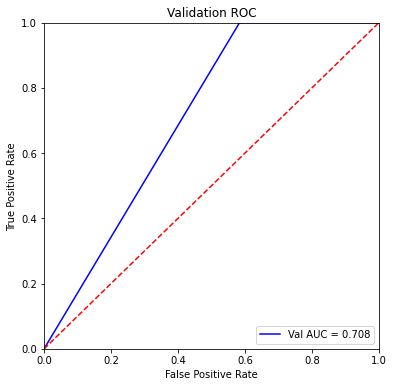

Correlation metrics
Accuracy 0.9479166666666664
Precision 0.9570518653321203
Recall 0.8919931325113155
F1 Score 0.9195575666163903
F1 Score 0.08036306834220887


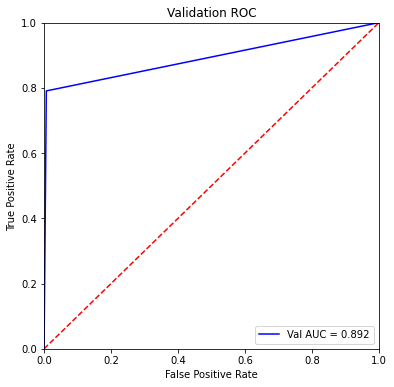

All metrics
Accuracy 0.9791666666666664
Precision 0.9632653061224484
Recall 0.9783049789292962
F1 Score 0.9705159705159706
F1 Score 0.016525547027587892


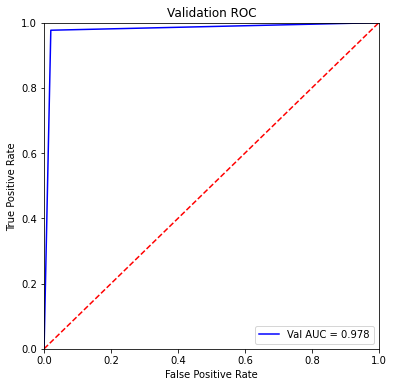

In [22]:
print("All metrics")
show_res(kmeans_predictions(label_data.drop(['label', 'time', 'txn_fail_num'],axis=1), NUMBER_OF_EXPERIMENTS))

print("Correlation metrics")
show_res(kmeans_predictions(label_data.drop(['label', 'time', 'txn_fail_num'],axis=1)[selected_features_names], NUMBER_OF_EXPERIMENTS))

print("All metrics")
show_res(kmeans_predictions(pca_df, NUMBER_OF_EXPERIMENTS))

# SUPERVISED METHODS
## KNN

In [23]:
from sklearn.neighbors import KNeighborsClassifier,RadiusNeighborsClassifier

# start_time = time.time()
# model = KNeighborsClassifier(n_neighbors=2)
# model.fit(X_train, Y_train)
# predictions = model.predict(X_test)
# result(Y_test, predictions, "Knn on all metrics")
# print("--- %s seconds ---" % (time.time() - start_time))

# start_time = time.time()
# model = KNeighborsClassifier(n_neighbors=2)
# model.fit(X_train[list(selected_features_names)], Y_train)
# predictions = model.predict(X_test[list(selected_features_names)])
# result(Y_test, predictions, "Knn on correlation metrics")
# print("--- %s seconds ---" % (time.time() - start_time))

# start_time = time.time()
# model = KNeighborsClassifier(n_neighbors=2)
# model.fit(X_pca_train, Y_pca_train)
# predictions = model.predict(X_pca_test)
# result(Y_pca_test, predictions, "Knn on pcs data")
# print("--- %s seconds ---" % (time.time() - start_time))

In [24]:
def knn_predictions(df, n):
    accuracy_, precision_, recall_, f1_score_,fpr_, tpr_, roc_auc_, time_ = [],[],[],[],[], [],[],[]
    for i in range(n):
        X_train, X_test, Y_train, Y_test = train_test_split(df, label_data.label, test_size=0.4, random_state=22)
        
        start_time = time.time()
        model = KNeighborsClassifier(n_neighbors=2)
        model.fit(X_train, Y_train)
        y_pred = model.predict(X_test)
        accuracy, precision, recall, f1_score, fpr, tpr, roc_auc = result(Y_test, y_pred)
        end_time = time.time()
        fpr_.append(fpr)
        tpr_.append(tpr)
        
        accuracy_.append(accuracy)
        precision_.append(precision)
        recall_.append(recall)
        f1_score_.append(f1_score)
        roc_auc_.append(roc_auc)
        time_.append(end_time - start_time)
    return np.mean(accuracy_), np.mean(precision_), np.mean(recall_), np.mean(f1_score_), np.average(fpr_, axis=0), np.average(tpr_, axis=0), np.mean(roc_auc_), np.mean(time_)

All metrics
Accuracy 0.9947916666666664
Precision 0.9886363636363634
Recall 0.9966442953020137
F1 Score 0.9925693718797163
F1 Score 0.042429277896881105


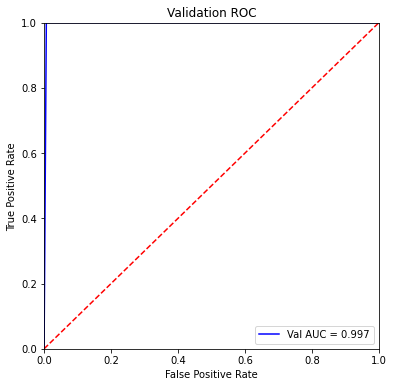

Correlation metrics
Accuracy 0.9947916666666664
Precision 0.9886363636363634
Recall 0.9966442953020137
F1 Score 0.9925693718797163
F1 Score 0.03762651324272156


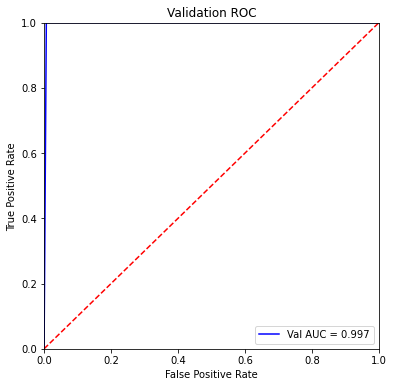

All metrics
Accuracy 0.9947916666666664
Precision 0.9886363636363634
Recall 0.9966442953020137
F1 Score 0.9925693718797163
F1 Score 0.009797057390213013


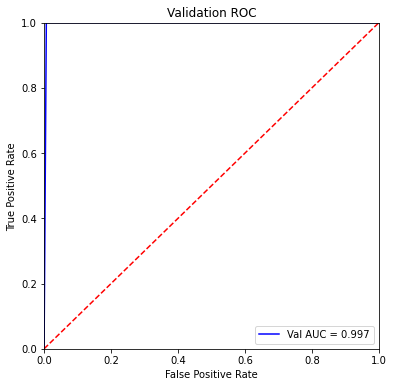

In [25]:
print("All metrics")
show_res(knn_predictions(label_data.drop(['label', 'time', 'txn_fail_num'],axis=1), NUMBER_OF_EXPERIMENTS))

print("Correlation metrics")
show_res(knn_predictions(label_data.drop(['label', 'time', 'txn_fail_num'],axis=1)[selected_features_names], NUMBER_OF_EXPERIMENTS))

print("All metrics")
show_res(knn_predictions(pca_df, NUMBER_OF_EXPERIMENTS))

# SVM

In [26]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
# start_time = time.time()
# clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
# clf.fit(X_train, Y_train)
# pred = clf.predict(X_test)
# result(Y_test, pred, "SVM on all metrics")
# print("--- %s seconds ---" % (time.time() - start_time))

# start_time = time.time()
# clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
# clf.fit(X_train[selected_features_names], Y_train)
# pred = clf.predict(X_test[selected_features_names])
# result(Y_test, pred, "SVM on correlation metrics")
# print("--- %s seconds ---" % (time.time() - start_time))

# start_time = time.time()
# clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
# clf.fit(X_pca_train, Y_pca_train)
# pred = clf.predict(X_pca_test)
# result(Y_pca_test, pred, "SVM on PCA metrics")
# print("--- %s seconds ---" % (time.time() - start_time))

def svm_predictions(df, n):
    accuracy_, precision_, recall_, f1_score_,fpr_, tpr_, roc_auc_, time_ = [],[],[],[],[], [],[],[]
    for i in range(n):
        X_train, X_test, Y_train, Y_test = train_test_split(df, label_data.label, test_size=0.4, random_state=22)
        
        start_time = time.time()
        clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
        clf.fit(X_train, Y_train)
        y_pred = clf.predict(X_test)
        accuracy, precision, recall, f1_score, fpr, tpr, roc_auc = result(Y_test, y_pred)
        end_time = time.time()
        fpr_.append(fpr)
        tpr_.append(tpr)
        
        accuracy_.append(accuracy)
        precision_.append(precision)
        recall_.append(recall)
        f1_score_.append(f1_score)
        roc_auc_.append(roc_auc)
        time_.append(end_time - start_time)
    return np.mean(accuracy_), np.mean(precision_), np.mean(recall_), np.mean(f1_score_), np.average(fpr_, axis=0), np.average(tpr_, axis=0), np.mean(roc_auc_), np.mean(time_)

All metrics
Accuracy 0.9947916666666664
Precision 0.9886363636363634
Recall 0.9966442953020137
F1 Score 0.9925693718797163
F1 Score 0.014069302320480346


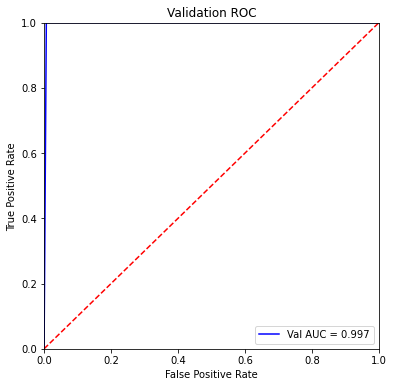

Correlation metrics
Accuracy 0.9947916666666664
Precision 0.9886363636363634
Recall 0.9966442953020137
F1 Score 0.9925693718797163
F1 Score 0.010122573614120483


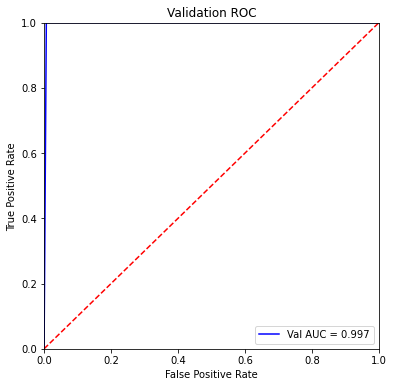

All metrics
Accuracy 0.9947916666666664
Precision 0.9886363636363634
Recall 0.9966442953020137
F1 Score 0.9925693718797163
F1 Score 0.007569926500320435


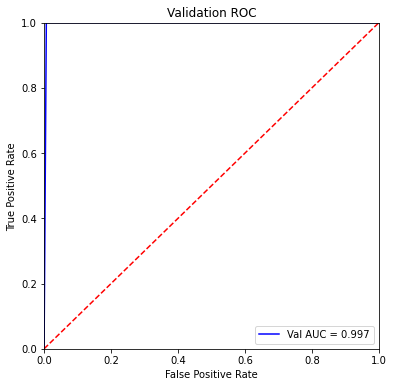

In [27]:
print("All metrics")
show_res(svm_predictions(label_data.drop(['label', 'time', 'txn_fail_num'],axis=1), NUMBER_OF_EXPERIMENTS))

print("Correlation metrics")
show_res(svm_predictions(label_data.drop(['label', 'time', 'txn_fail_num'],axis=1)[selected_features_names], NUMBER_OF_EXPERIMENTS))

print("All metrics")
show_res(svm_predictions(pca_df, NUMBER_OF_EXPERIMENTS))

# Random forest

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

clf = RandomForestClassifier(max_depth=2, random_state=0)

# start_time = time.time()
# clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
# clf.fit(X_train, Y_train)
# pred = clf.predict(X_test)
# result(Y_test, pred, "SVM on all metrics")
# print("--- %s seconds ---" % (time.time() - start_time))

# start_time = time.time()
# clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
# clf.fit(X_train[selected_features_names], Y_train)
# pred = clf.predict(X_test[selected_features_names])
# result(Y_test, pred, "SVM on correlation metrics")
# print("--- %s seconds ---" % (time.time() - start_time))

# start_time = time.time()
# clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
# clf.fit(X_pca_train, Y_pca_train)
# pred = clf.predict(X_pca_test)
# result(Y_pca_test, pred, "SVM on PCA metrics")
# print("--- %s seconds ---" % (time.time() - start_time))


def rf_predictions(df, n):
    accuracy_, precision_, recall_, f1_score_,fpr_, tpr_, roc_auc_, time_ = [],[],[],[],[], [],[],[]
    for i in range(n):
        X_train, X_test, Y_train, Y_test = train_test_split(df, label_data.label, test_size=0.4, random_state=22)
        
        start_time = time.time()
        clf = RandomForestClassifier(max_depth=10, random_state=5)
        clf.fit(X_train, Y_train)
        y_pred = clf.predict(X_test)
        accuracy, precision, recall, f1_score, fpr, tpr, roc_auc = result(Y_test, y_pred)
        end_time = time.time()
        fpr_.append(fpr)
        tpr_.append(tpr)
        
        accuracy_.append(accuracy)
        precision_.append(precision)
        recall_.append(recall)
        f1_score_.append(f1_score)
        roc_auc_.append(roc_auc)
        time_.append(end_time - start_time)
    return np.mean(accuracy_), np.mean(precision_), np.mean(recall_), np.mean(f1_score_), np.average(fpr_, axis=0), np.average(tpr_, axis=0), np.mean(roc_auc_), np.mean(time_)


All metrics
Accuracy 0.9947916666666664
Precision 0.9886363636363634
Recall 0.9966442953020137
F1 Score 0.9925693718797163
F1 Score 0.12778148436546324


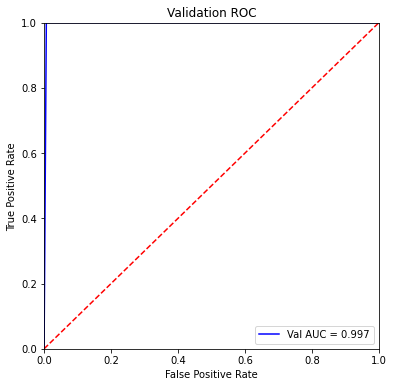

Correlation metrics
Accuracy 0.9947916666666664
Precision 0.9886363636363634
Recall 0.9966442953020137
F1 Score 0.9925693718797163
F1 Score 0.12821050238609313


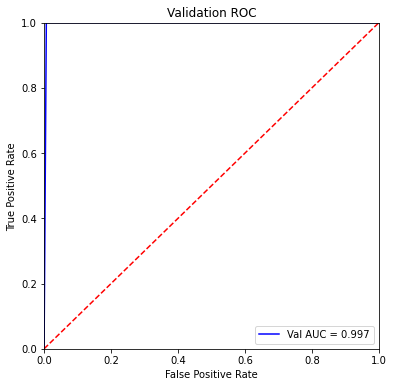

All metrics
Accuracy 0.9947916666666664
Precision 0.9886363636363634
Recall 0.9966442953020137
F1 Score 0.9925693718797163
F1 Score 0.1302427532672882


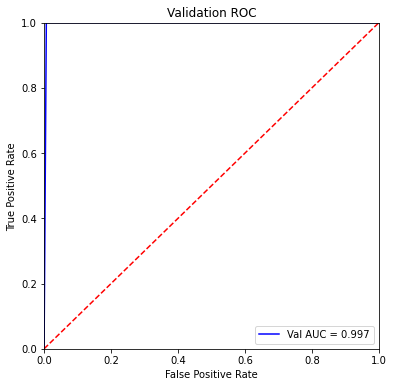

In [29]:
print("All metrics")
show_res(rf_predictions(label_data.drop(['label', 'time', 'txn_fail_num'],axis=1), NUMBER_OF_EXPERIMENTS))

print("Correlation metrics")
show_res(rf_predictions(label_data.drop(['label', 'time', 'txn_fail_num'],axis=1)[selected_features_names], NUMBER_OF_EXPERIMENTS))

print("All metrics")
show_res(rf_predictions(pca_df, NUMBER_OF_EXPERIMENTS))

# Ensamble learning

# Majority vote for supervised models

In [86]:
import numpy as np
from sklearn.ensemble import VotingClassifier

def ensamble(df):

    X_train, X_test, Y_train, Y_test = train_test_split(df, label_data.label, test_size=0.4, random_state=22)
    
    dbscan_clf = DBSCAN(eps=3, min_samples=2)
    if_clf=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.12), \
                            max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
    kmeans_clf = KMeans(n_clusters=2)
    KNN_clf = KNeighborsClassifier(n_neighbors=2)
    svm_clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
    rf_clf = RandomForestClassifier(max_depth=10, random_state=5)

    # dbscan, IF and kmeans does not work since it is no classifier
    eclf1 = VotingClassifier(estimators=[
            ('knn', KNN_clf), \
            ('svm', svm_clf), ('random forest', rf_clf)], voting='hard')

    eclf1 = eclf1.fit(X_train, Y_train)
    eclf1_predictions = eclf1.predict(X_test)
    print(eclf1.predict(X_test))
    print(Y_test)

#     np.array_equal(eclf1.named_estimators_.lr.predict(X_test),
#                    eclf1.named_estimators_['lr'].predict(X_test))

#     eclf2 = VotingClassifier(estimators=[
#             ('knn', KNN_clf), \
#             ('svm', svm_clf), ('random forest', rf_clf)],\
#             voting='soft')

#     eclf2 = eclf2.fit(X_train, Y_train)
#     eclf2_predictions = eclf2.predict(X_test)

#     eclf3 = VotingClassifier(estimators=[('knn', KNN_clf), \
#             ('svm', svm_clf), ('random forest', rf_clf)],
#             voting='soft', weights=[2,1,1],
#             flatten_transform=True)
#     eclf3 = eclf3.fit(X_train, Y_train)
#     print(eclf3.predict(X_test))

    return eclf1
    
    


In [87]:
ensamble(label_data.drop(['label', 'time', 'txn_fail_num'],axis=1))

[0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 1 0 1
 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0
 0 0 0 0 1 0 0 1 1 0 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 0 0 0 0 1 1
 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 1
 0 0 1 0 0 0 0]
454    0
354    0
378    0
476    0
250    1
      ..
280    1
422    0
128    0
182    0
346    0
Name: label, Length: 192, dtype: int64


VotingClassifier(estimators=[('knn', KNeighborsClassifier(n_neighbors=2)),
                             ('svm',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('svc', SVC(gamma='auto'))])),
                             ('random forest',
                              RandomForestClassifier(max_depth=10,
                                                     random_state=5))])

In [108]:
def hard_vote_ensamble(df, n):
    accuracy_, precision_, recall_, f1_score_,fpr_, tpr_, roc_auc_, time_ = [],[],[],[],[], [],[],[]
    for i in range(n):
        X_train, X_test, Y_train, Y_test = train_test_split(df, label_data.label, test_size=0.4, random_state=22)
        dbscan_clf = DBSCAN(eps=3, min_samples=2)
        if_clf=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.12), \
                                max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
        kmeans_clf = KMeans(n_clusters=2)
        KNN_clf = KNeighborsClassifier(n_neighbors=2)
        svm_clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
        rf_clf = RandomForestClassifier(max_depth=10, random_state=5)

        
        
        start_time = time.time()
        # dbscan, IF and kmeans does not work since it is no classifier
        eclf1 = VotingClassifier(estimators=[
                ('knn', KNN_clf), \
                ('svm', svm_clf), ('random forest', rf_clf)], voting='hard')

        eclf1 = eclf1.fit(X_train, Y_train)
        y_pred = eclf1.predict(X_test)
        
        accuracy, precision, recall, f1_score, fpr, tpr, roc_auc = result(Y_test, y_pred)
        end_time = time.time()
        fpr_.append(fpr)
        tpr_.append(tpr)
        
        accuracy_.append(accuracy)
        precision_.append(precision)
        recall_.append(recall)
        f1_score_.append(f1_score)
        roc_auc_.append(roc_auc)
        time_.append(end_time - start_time)
    return np.mean(accuracy_), np.mean(precision_), np.mean(recall_), np.mean(f1_score_), np.mean(fpr_), np.mean(tpr_), np.mean(roc_auc_), np.mean(time_)

Accuracy 0.9947916666666664
Precision 0.9886363636363634
Recall 0.9966442953020137
F1 Score 0.9925693718797163
Time 0.2615642614364624


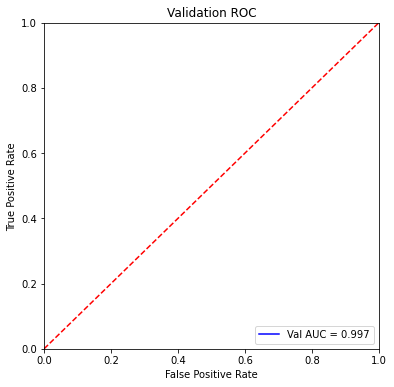

Accuracy 0.9947916666666664
Precision 0.9886363636363634
Recall 0.9966442953020137
F1 Score 0.9925693718797163
Time 0.2673588600158691


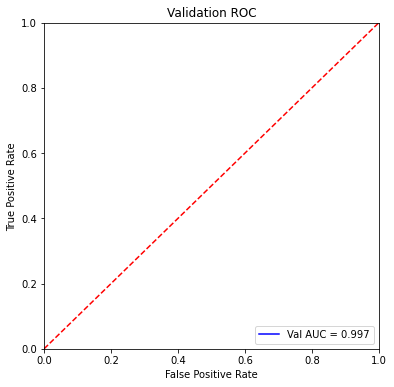

Accuracy 0.9947916666666664
Precision 0.9886363636363634
Recall 0.9966442953020137
F1 Score 0.9925693718797163
Time 0.13167227053642272


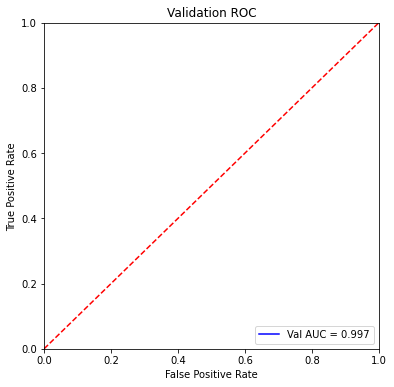

In [110]:
show_res(hard_vote_ensamble(label_data.drop(['label', 'time', 'txn_fail_num'],axis=1), NUMBER_OF_EXPERIMENTS))

show_res(hard_vote_ensamble(label_data.drop(['label', 'time', 'txn_fail_num'],axis=1)[selected_features_names], NUMBER_OF_EXPERIMENTS))

show_res(hard_vote_ensamble(pca_df, NUMBER_OF_EXPERIMENTS))

# Average vote for supervised and unsupervised models

In [145]:
# AVERGE VOTING then round.

def average_vote_ensamble(df, n):
    accuracy_, precision_, recall_, f1_score_,fpr_, tpr_, roc_auc_, time_ = [],[],[],[],[], [],[],[]
    for i in range(n):
        X_train, X_test, Y_train, Y_test = train_test_split(df, label_data.label, test_size=0.4, random_state=22)
        dbscan_clf = DBSCAN(eps=3, min_samples=2)
        if_clf=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.12), \
                                max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0).fit(X_train, Y_train)
        kmeans_clf = KMeans(n_clusters=2).fit(X_train, Y_train)
        KNN_clf = KNeighborsClassifier(n_neighbors=2).fit(X_train, Y_train)
        svm_clf = make_pipeline(StandardScaler(), SVC(gamma='auto')).fit(X_train, Y_train)
        rf_clf = RandomForestClassifier(max_depth=10, random_state=5).fit(X_train, Y_train)

        
        
        start_time = time.time()
        # dbscan, IF and kmeans does not work since it is no classifier
        
        dbscan_pred = dbscan_clf.fit_predict(X_test)
        if_pred = if_clf.predict(X_test)
        kmeans_pred = kmeans_clf.predict(X_test)
        KNN_pred = KNN_clf.predict(X_test)
        svm_pred = svm_clf.predict(X_test)
        rf_pred = rf_clf.predict(X_test)
        
        average_ypred = [int(np.mean(np.array(i))) for i in zip(kmeans_pred, KNN_pred, svm_pred, rf_pred)]
        
        accuracy, precision, recall, f1_score, fpr, tpr, roc_auc = result(Y_test, average_ypred)
        end_time = time.time()
        fpr_.append(fpr)
        tpr_.append(tpr)
        
        accuracy_.append(accuracy)
        precision_.append(precision)
        recall_.append(recall)
        f1_score_.append(f1_score)
        roc_auc_.append(roc_auc)
        time_.append(end_time - start_time)
    return np.mean(accuracy_), np.mean(precision_), np.mean(recall_), np.mean(f1_score_), np.average(fpr_, axis=0), np.average(tpr_, axis=0), np.mean(roc_auc_), np.mean(time_)

      

Accuracy 0.7760416666666666
Precision 0.3880208333333333
Recall 0.5
F1 Score 0.436950146627566
Time 0.14203643798828125


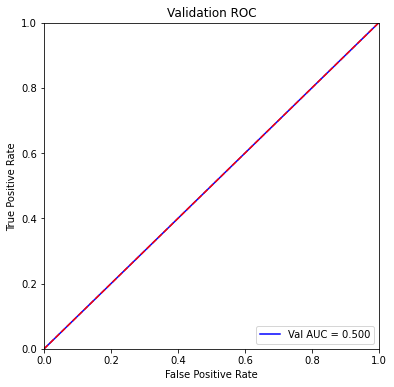

Accuracy 0.9479166666666666
Precision 0.95705186533212
Recall 0.8919931325113157
F1 Score 0.91955756661639
Time 0.1386568546295166


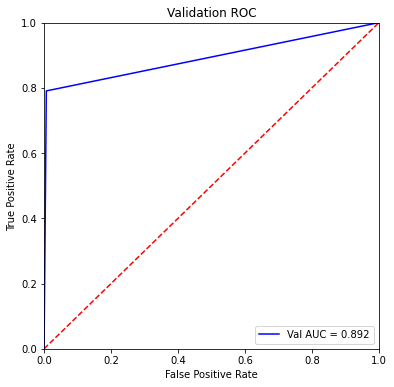

Accuracy 0.7760416666666666
Precision 0.6394736842105263
Recall 0.5082722022787576
F1 Score 0.45880039331366756
Time 0.05665469169616699


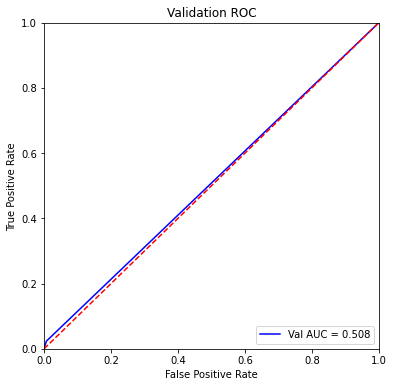

In [146]:
show_res(average_vote_ensamble(label_data.drop(['label', 'time', 'txn_fail_num'],axis=1), NUMBER_OF_EXPERIMENTS))

show_res(average_vote_ensamble(label_data.drop(['label', 'time', 'txn_fail_num'],axis=1)[selected_features_names], NUMBER_OF_EXPERIMENTS))

show_res(average_vote_ensamble(pca_df, NUMBER_OF_EXPERIMENTS))

# Majority vote for supervised and unsupervised models

In [184]:
# AVERGE VOTING then round.
def majority_vote_ensamble(df, n):
    accuracy_, precision_, recall_, f1_score_,fpr_, tpr_, roc_auc_, time_ = [],[],[],[],[], [],[],[]
    for i in range(n):
        X_train, X_test, Y_train, Y_test = train_test_split(df, label_data.label, test_size=0.4, random_state=22)
        dbscan_clf = DBSCAN(eps=3, min_samples=2)
        if_clf=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.12), \
                                max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0).fit(X_train)
        kmeans_clf = KMeans(n_clusters=2).fit(X_train, Y_train)
        KNN_clf = KNeighborsClassifier(n_neighbors=2).fit(X_train, Y_train)
        svm_clf = make_pipeline(StandardScaler(), SVC(gamma='auto')).fit(X_train, Y_train)
        rf_clf = RandomForestClassifier(max_depth=10, random_state=5).fit(X_train, Y_train)

        
        
        start_time = time.time()
        # dbscan, IF and kmeans does not work since it is no classifier
        
        dbscan_pred = dbscan_clf.fit_predict(X_test)
        if_pred = if_clf.predict(X_test)
        
        if_pred = np.array(if_pred)
        if_pred[if_pred == -1] = 1
        
        kmeans_pred = kmeans_clf.predict(X_test)
        KNN_pred = KNN_clf.predict(X_test)
        svm_pred = svm_clf.predict(X_test)
        rf_pred = rf_clf.predict(X_test)
        dbscan_pred = np.array(dbscan_pred)
        dbscan_pred[dbscan_pred == -1] = 1
        
        stack_counts = (np.column_stack([dbscan_pred, if_pred, kmeans_pred, KNN_pred, svm_pred, rf_pred, dbscan_pred]))
        counts = [np.bincount(i) for i in stack_counts]
        majority_result = [np.argmax(i) for i in counts]

        average_ypred = [int(np.mean(np.array(i))) for i in zip(kmeans_pred, KNN_pred, svm_pred, rf_pred)]
        
        accuracy, precision, recall, f1_score, fpr, tpr, roc_auc = result(Y_test, average_ypred)
        end_time = time.time()
        fpr_.append(fpr)
        tpr_.append(tpr)
        
        accuracy_.append(accuracy)
        precision_.append(precision)
        recall_.append(recall)
        f1_score_.append(f1_score)
        roc_auc_.append(roc_auc)
        time_.append(end_time - start_time)
    return np.mean(accuracy_), np.mean(precision_), np.mean(recall_), np.mean(f1_score_), np.average(fpr_, axis=0), np.average(tpr_, axis=0), np.mean(roc_auc_), np.mean(time_)

      

Accuracy 0.7760416666666666
Precision 0.3880208333333333
Recall 0.5
F1 Score 0.436950146627566
Time 0.1685476303100586


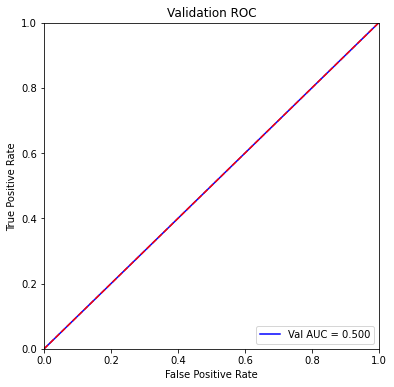

Accuracy 0.9479166666666666
Precision 0.95705186533212
Recall 0.8919931325113157
F1 Score 0.91955756661639
Time 0.14410924911499023


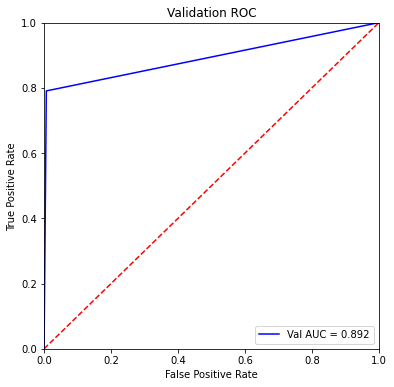

Accuracy 0.9947916666666666
Precision 0.9966666666666666
Recall 0.9883720930232558
F1 Score 0.9924454062561479
Time 0.05678081512451172


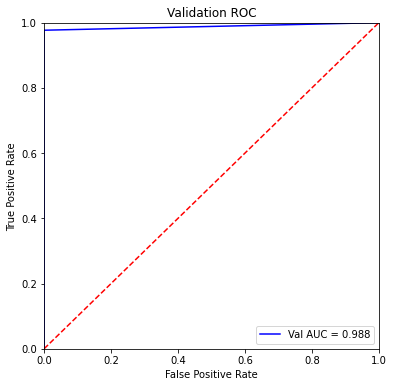

In [190]:
show_res(majority_vote_ensamble(label_data.drop(['label', 'time', 'txn_fail_num'],axis=1), NUMBER_OF_EXPERIMENTS))
show_res(majority_vote_ensamble(label_data.drop(['label', 'time', 'txn_fail_num'],axis=1)[selected_features_names], NUMBER_OF_EXPERIMENTS))
show_res(majority_vote_ensamble(pca_df, NUMBER_OF_EXPERIMENTS))


In [ ]:
# TODO
# undersampling
# Weighted voting